ライブラリインポート

In [1]:
from collections import namedtuple
import csv
import math
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# 開口部の評価方法に関する仕様書

- LV2(#2) 計算方法名  
    - LV3(#3) 入力値  
    - LV3(#3) 出力値  
    - LV3(#3) 計算方法  
        - LV4(#4) 各計算方法  
    - LV3(#3) 計算例

　本資料は開口部における熱貫流率および日射熱取得率を計算する方法についてまとめたものです。本資料は計算方法を示すとともに、プログラムのテストの入出力についてもまとめています。  
　本資料は以下のパートから構成されています。  
  
1. 気象データの読込  
2. 暖冷房期間の設定
3. 開口面日射量の計算  
　3.1. 太陽高度角・太陽方位角  
　3.2. 拡散日射の微小要素分割  
　　3.2.1. 天空日射  
　　3.2.2. 地表面反射日射  
　3.3. 直散分離（Watanabe model）  
　3.4. 斜面日射量（Isotropic model）  
4. ひさしの日除け計算  
5. 窓の日射熱取得率の計算  
　5.1. グレージング複合体の日射熱取得率  
　　5.1.1. 面材の光学特性  
　　　5.1.1.1. ガラス  
　　　5.1.1.2. ロールスクリーン  
　　　5.1.1.3. ブラインド※  
　　　　5.1.1.3.1. 幾何学形状の作成※  
　　　　5.1.1.3.2. 鏡面反射成分の計算※  
　　　　5.1.1.3.3. 拡散反射成分の計算※  
　　　　5.1.1.3.4. 全体計算※  
　　5.1.2. 短波長放射（日射）の多重反射  
　　5.1.3. 熱抵抗  
　　　5.1.3.1. 中空層の熱抵抗  
　　　5.1.3.2. 表面熱伝達抵抗  
　　　5.1.3.3. 熱平衡  
　　5.1.4. 全体計算  
　5.2. フレームの日射熱取得率  
　5.3. 全体計算  
6. 窓の熱貫流率の計算※  

※は、将来的に記述するパートです。


## 1. 気象データの読込  

説明：気温及び全天日射量を読み込む。

In [2]:
location = '3639999'

#気象データの読込
w_tmp = np.genfromtxt(location + '_tmp.CSV', skip_header = 1, delimiter = ',', dtype = float)  #外気温
w_ig = np.genfromtxt(location + '_ig.CSV', skip_header = 1, delimiter = ',', dtype = float)    #全天日射量

hr = np.zeros(8760)     #通算時間数
tmp = np.zeros(8760)    #外気温(℃)
ig = np.zeros(8760)     #全天日射量(MJ/(m2h))

#データの配列
for i in range(0, 365):
    for j in range(0, 24):
        hr[i * 24 + j] = np.array(i * 24 + j + 1)
        tmp[i * 24 + j] = np.array(w_tmp[i, j + 1])
        ig[i * 24 + j] = np.array(w_ig[i, j + 1])

In [3]:
#確認用気象データの読込
w_ib = np.genfromtxt(location + '_ib.CSV', skip_header = 1, delimiter = ',', dtype = float)  #法線面直達日射量
w_id = np.genfromtxt(location + '_id.CSV', skip_header = 1, delimiter = ',', dtype = float)  #水平面天空日射量
w_itb = np.genfromtxt(location + '_itb.CSV', skip_header = 1, delimiter = ',', dtype = float)  #斜面直達日射量
w_itd = np.genfromtxt(location + '_itd.CSV', skip_header = 1, delimiter = ',', dtype = float)  #斜面天空日射量
w_itr = np.genfromtxt(location + '_itr.CSV', skip_header = 1, delimiter = ',', dtype = float)  #斜面地表面反射日射量
w_h = np.genfromtxt(location + '_h.CSV', skip_header = 1, delimiter = ',', dtype = float)  #太陽高度角
w_A = np.genfromtxt(location + '_A.CSV', skip_header = 1, delimiter = ',', dtype = float)  #太陽方位角

ib_ea = np.zeros(8760)
id_ea = np.zeros(8760)
itb_ea = np.zeros(8760)
itd_ea = np.zeros(8760)
itr_ea = np.zeros(8760)
h_ea = np.zeros(8760)
A_ea = np.zeros(8760)

for i in range(0, 365):
    for j in range(0, 24):
        ib_ea[i * 24 + j] = np.array(w_ib[i, j + 1])
        id_ea[i * 24 + j] = np.array(w_id[i, j + 1])
        h_ea[i * 24 + j] = np.array(w_h[i, j + 1])
        itb_ea[i * 24 + j] = np.array(w_itb[i, j + 1])
        itd_ea[i * 24 + j] = np.array(w_itd[i, j + 1])
        itr_ea[i * 24 + j] = np.array(w_itr[i, j + 1])
        A_ea[i * 24 + j] = np.array(w_A[i, j + 1]) 

## 2. 暖冷房期間の設定  

（参考：平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）Ver.2.2 算定方法 1　概要と用語の定義）  

暖房期間は、日平均外気温をフーリエ変換した年周期成分が15℃以下となる期間とする。

冷房期間は、日最高外気温をフーリエ変換した年周期成分が23℃以上となる期間とする。

通算日数と(日平均/日最高)外気温の関係から以下の回帰曲線を求め、暖房期間/冷房期間を判定する。

$ \begin{align}y = a + b ･ \sin\biggl[\frac{2\pi ･ (x - c)}{365}\biggr]\end{align}$ ･････････････････････････････････････････ (2-a)  


Regression coefficients:
Cooling: a = 19.9120547936 b = 10.22900077 c = 485.838331248
Heating: a = 16.5639155257 b = 10.4339448788 c = 486.696032744
Solar: a = 12.3263013703 b = -4.00855862459 c = 248.003418058
Heating/cooling periods:
Cooling: begining day = 139 , ending day = 285
Heating: ending day= 112 , begining day= 313


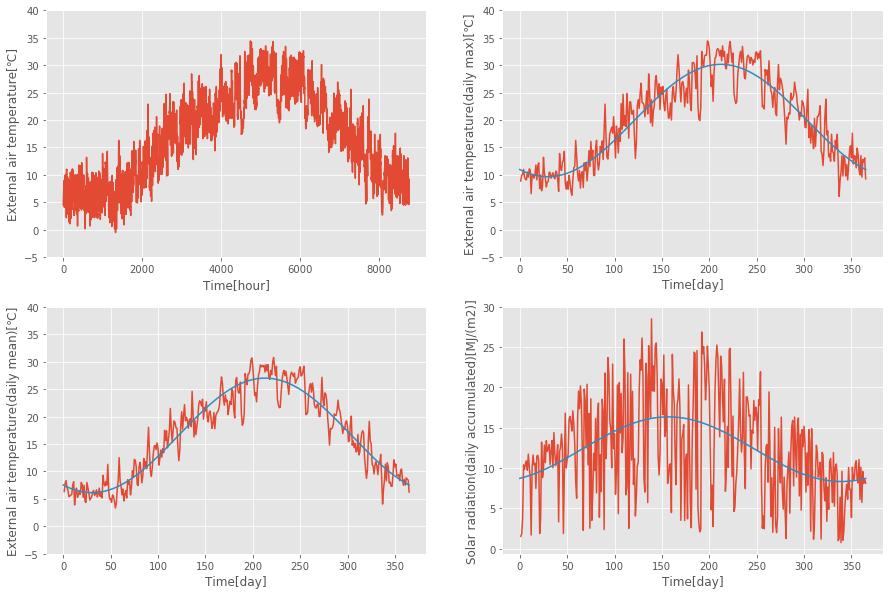

In [4]:
day = np.zeros(365)     #通算日数
tmp_max = np.zeros(365) #日最高外気温
tmp_ave = np.zeros(365) #日平均外気温
ig_sum = np.zeros(365)  #日積算日射量

#日最高外気温・日平均外気温・日積算日射量の計算
for i in range(0, 365):
    day[i] = np.array(i + 1)
    tmp_max[i] = np.max(np.array(w_tmp[i, 1:25]))
    tmp_ave[i] = np.average(np.array(w_tmp[i, 1:25]))
    ig_sum[i] = np.sum(np.array(w_ig[i, 1:25]))

#日最高外気温に対する回帰係数の計算
def ft_cooling(x, a_c, b_c, c_c):
    return a_c + b_c * np.sin(2 * math.pi *(x - c_c) / 365.)

para_c, cov = scipy.optimize.curve_fit(ft_cooling, day, tmp_max)
day_c = np.arange(0, 366, 1)
tmp_c = para_c[0] + para_c[1] * np.sin(2 * math.pi * (day_c - para_c[2]) / 365.)

print ('Regression coefficients:')
print ('Cooling: a =', str(para_c[0]),'b =', str(para_c[1]),'c =', str(para_c[2]))

#日平均外気温に対する回帰係数の計算
def ft_heating(x, a_h, b_h, c_h):
    return a_h + b_h * np.sin(2. * math.pi *(x - c_h) / 365.)

para_h, cov = scipy.optimize.curve_fit(ft_heating, day, tmp_ave)
day_h = np.arange(0, 366, 1)
tmp_h = para_h[0] + para_h[1] * np.sin(2. * math.pi * (day_h - para_h[2]) / 365.)

print ('Heating: a =', str(para_h[0]), 'b =', str(para_h[1]), 'c =', str(para_h[2]))

#日積算日射量に対する回帰係数の計算
def ft_solar(x, a_s, b_s, c_s):
    return a_s + b_s * np.sin(2. * math.pi *(x - c_s) / 365.)

para_s, cov = scipy.optimize.curve_fit(ft_solar, day, ig_sum)
day_s = np.arange(0, 366, 1)
ig_s = para_s[0] + para_s[1] * np.sin(2. * math.pi * (day_s - para_s[2]) / 365.)

print ('Solar: a =', str(para_s[0]), 'b =', str(para_s[1]), 'c =', str(para_s[2]))

#冷房期間の計算
day_c23_bgn = day_c[np.min(np.where(tmp_c >= 23.))]
day_c23_end = day_c[np.max(np.where(tmp_c >= 23.))]

print ('Heating/cooling periods:')
print ('Cooling: begining day =', day_c23_bgn, ', ending day =', day_c23_end)

#暖房期間の計算
day_h15_end = day_h[np.min(np.where(tmp_h > 15.))] - 1
day_h15_bgn = day_h[np.max(np.where(tmp_h > 15.))] + 1

print ('Heating: ending day=', day_h15_end, ', begining day=', day_h15_bgn)

#グラフの描画
fig = plt.figure(figsize=(15,10))
plt.style.use('ggplot')

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(hr, tmp, color = 'C0')
ax1.set_yticks([5 * (i - 1) for i in range(10)])
ax1.set_xlabel('Time[hour]', fontsize = 12)
ax1.set_ylabel('External air temperature[℃]', fontsize = 12)

ax2.plot(day, tmp_max, color = 'C0')
ax2.plot(day_c, tmp_c, color = 'C1')
ax2.set_yticks([5 * (i - 1) for i in range(10)])
ax2.set_xlabel('Time[day]', fontsize = 12)
ax2.set_ylabel('External air temperature(daily max)[℃]', fontsize = 12)

ax3.plot(day, tmp_ave, color = 'C0')
ax3.plot(day_h, tmp_h, color = 'C1')
ax3.set_yticks([5 * (i - 1) for i in range(10)])
ax3.set_xlabel('Time[day]', fontsize = 12)
ax3.set_ylabel('External air temperature(daily mean)[℃]', fontsize = 12)

ax4.plot(day, ig_sum, color = 'C0')
ax4.plot(day_s, ig_s, color = 'C1')
ax4.set_yticks([5 * i for i in range(7)])
ax4.set_xlabel('Time[day]', fontsize = 12)
ax4.set_ylabel('Solar radiation(daily accumulated)[MJ/(m2)]', fontsize = 12)

plt.show()

## 3. 開口面日射量の計算  

### 3.1. 太陽位置  

説明：任意の時刻・緯度・経度における太陽高度角・太陽方位角を計算する。

### 入力値  

$ Y $ ：西暦年（year）  
$ D $ ：1月1日を初日（$D=1$）とする計算対象日の年通算日 (day)  
$ T_m $ ：標準時 (h)  
$ \Phi $ ：計算対象地点の緯度 (°)  
$ L $ ：計算対象地点の経度 (°)  

### 出力値

$ h $ ：太陽高度角 (°)  
$ A $ ：太陽方位角 (°)  

### 計算方法

#### データ構造と値の範囲

$Y$・$D$・$T_m$・$\Phi$・$L$の組み合わせを1つの変数（タプル）で表し"sp_input"とする。  
$h$は0°以上、90°以下の値をとる（地平：0°、天頂：90°）。  
$A$は-180°以上、180°以下の値をとる（東：-90°、南：0°、西：90°）。

In [5]:
sp_input = namedtuple('sp_input','sp_year sp_nday sp_tm sp_lat sp_lon')
#sp_year：西暦年（year）  
#sp_nday：1月1日を初日（$D=1$）とする計算対象日の年通算日 (day)  
#sp_tm：標準時 (h)  
#sp_lat：計算対象地点の緯度 (°)  
#sp_lon：計算対象地点の経度 (°)  

#### 太陽高度角及び太陽方位角の計算

（参考：拡張アメダス気象データ1981-2000解説書 8.1　太陽位置の計算）  

太陽高度角$ h $、太陽方位角$ A $の計算方法を以下に示す。  

$ \begin{align}\sin h = \sin\Phi ･ \sin \delta + \cos \Phi ･ \cos \delta ･ \cos t\end{align}$ ････････････････ (3.1-a)  

$ \begin{align}\sin A = \frac{\cos\delta ･ \sin t}{\cos h}\end{align}$ ････････････････････････････････････ (3.1-b)  

$ \begin{align}\cos A = \frac{\sin h ･ \sin\Phi - \sin\delta}{\cos h ･ \cos\phi}\end{align}$ ････････････････････････････ (3.1-c)  

$ \begin{align}t = 15 ･ (T_m - 12) + (L - L_0) + E_t\end{align}$ ･･････････････････････ (3.1-d)  

$ \begin{align}\sin\delta = \cos(v + \epsilon) ･ \sin\delta_0\end{align}$ ･･･････････････････････････････ (3.1-e)  

$ \begin{align}E_t = (M - v) - \tan^{-1}\biggl[\frac{0.043 ･ \sin 2(v + \epsilon)}{1 - 0.043 ･ \cos 2(v + \epsilon)}\biggr]\end{align}$ ･････････ (3.1-f)  

$ \begin{align}v = M + 1.914 ･ \sin M + 0.02 ･ \sin(2M)\end{align}$ ･･････････････････ (3.1-g)  

$ \begin{align}\epsilon = 12.3901 + 0.0172 ･ \biggl(n + \frac{M}{360}\biggr)\end{align}$ ･････････････････････ (3.1-h)  

$ \begin{align}M = \frac{360 ･ (D - d_0)}{D_y} \end{align}$ ･････････････････････････････････････ (3.1-i)  

$ \begin{align}d_0 = 3.71 + 0.2596 ･ n - INT\biggl[\frac{n+3}{4}\biggr]\end{align}$ ･･･････････････････ (3.1-j)  

$ \begin{align}n = Y - 1968\end{align}$ ･･････････････････････････････････････････ (3.1-k)  

ここで、  

$ \delta $ ：赤緯 (°)  
$ t $ ：時角 (°)  
$ L_0 $ ：標準時の地点の経度（=135.0（日本の場合）） (°)  
$ E_t $ ：均時差 (°)  
$ v $ ：真近点離角 (°)  
$ \epsilon $ ：近日点と冬至点の角度 (°)  
$ \delta_0 $ ：北半球の冬至の日赤緯（= -23.4393） (°)  
$ M $ ：平均近点離角 (°)  
$ n $ ：1968年との年差 (year)  
$ d_0 $ ：平均軌道上の近日点通過日（暦表時による1968年1月1日正午基準の日差）(day)  
$ D_y $ ：近点年（近日点基準の公転周期日数）（= 365.2596） (day)  
$ INT[] $ ：小数点以下切り捨て  
$ Y $ ：西暦年 (year)  

である。  

In [6]:
#太陽位置の計算
def solar_position(L):
    sp_r = np.zeros(2)
    sp_n = L.sp_year - 1968.
    sp_d0 = 3.71 + 0.2596 * sp_n - int((sp_n + 3.) / 4.)
    sp_Dy = 365.2596
    sp_M = 360. * (L.sp_nday - sp_d0) / sp_Dy
    sp_eps = 12.3901 + 0.0172 * (sp_n + sp_M / 360.)
    sp_v = sp_M + 1.914 * math.sin(math.radians(sp_M)) + 0.02 * math.sin(math.radians(2. * sp_M))
    sp_veps = math.radians(sp_v + sp_eps)
    sp_et = (sp_M - sp_v) - math.degrees(math.atan(0.043 * math.sin(2. * sp_veps) / (1. - 0.043 * math.cos(2. * sp_veps))))
    sp_dlt0 = math.radians(-23.4393)
    sp_sindlt = math.cos(sp_veps) * math.sin(sp_dlt0)
    sp_cosdlt = (abs(1. - sp_sindlt ** 2.)) ** 0.5
    sp_lons = 135.
    sp_t = 15. * (L.sp_tm - 12.) + (L.sp_lon - sp_lons) + sp_et
    sp_latrad = math.radians(L.sp_lat)
    sp_trad = math.radians(sp_t)
    sp_sinh = math.sin(sp_latrad) * sp_sindlt + math.cos(sp_latrad) * sp_cosdlt * math.cos(sp_trad)
    sp_cosh = (1. - sp_sinh ** 2.) ** 0.5
    sp_sinA = sp_cosdlt * math.sin(sp_trad) / sp_cosh
    sp_cosA = (sp_sinh * math.sin(sp_latrad) - sp_sindlt) / (sp_cosh * math.cos(sp_latrad))
    if sp_sinh > 0.:
        sp_r[0] = math.degrees(math.asin(sp_sinh))
        if sp_sinA > 0.:
            sp_r[1] = 90. - math.degrees(math.atan(sp_cosA / sp_sinA))
        elif sp_sinA < 0.:
            sp_r[1] = - 90. - math.degrees(math.atan(sp_cosA / sp_sinA))
        elif sp_sinA == 0.:
            sp_r[1] = 0.
    return sp_r

### 計算例

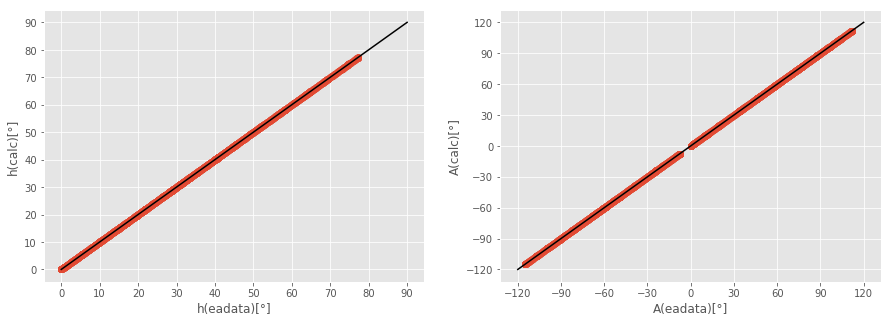

In [7]:
sp_result = np.empty((5,8760))

for i in range(0, 8760):
    sp_in = sp_input(1995, int((i + 1.) / 24.) + 1., ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24., 35. + 41.2 / 60., 139. + 45.9 / 60.)
    sp_result[0][i] = i + 1.                                           #年通算時間
    sp_result[1][i] = int((i + 1.) / 24.) + 1.                         #年通算日
    sp_result[2][i] = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.     #時刻
    sp_result[3][i] = solar_position(sp_in)[0]                         #太陽高度角
    sp_result[4][i] = solar_position(sp_in)[1]                         #太陽方位角
    
np.savetxt('3639999_out_sp.csv', np.transpose(sp_result), fmt='%.10f', delimiter=',')

#グラフの描画
fig = plt.figure(figsize=(15,5))
plt.style.use('ggplot')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(h_ea[0:8760], sp_result[3][0:8760], color = 'C0') #太陽高度角の比較
ax1.plot([0,90],[0,90], color = (0,0,0))
ax1.set_xticks([10 * i for i in range(10)])
ax1.set_yticks([10 * i for i in range(10)])
ax1.set_xlabel('h(eadata)[°]', fontsize = 12)
ax1.set_ylabel('h(calc)[°]', fontsize = 12)

ax2.scatter(A_ea[0:8760], sp_result[4][0:8760], color = 'C0') #太陽方位角の比較
ax2.plot([-120,120],[-120,120], color = (0,0,0))
ax2.set_xticks([30 * (i - 4) for i in range(9)])
ax2.set_yticks([30 * (i - 4) for i in range(9)])
ax2.set_xlabel('A(eadata)[°]', fontsize = 12)
ax2.set_ylabel('A(calc)[°]', fontsize = 12)

plt.show()

### 3.2. 拡散日射の微小要素分割

### 3.2.1. 天空日射

説明：開口部が垂直窓の場合に、天空日射量に対する天空上の任意の微小要素からの天空日射量の割合を計算する。

### 入力値  

$ N_{d,\Phi} $：天空の緯度方向の分割数  
$ N_{d,L} $：天空の経度方向の分割数  
$ l $：天空の緯度方向の$l$番目の分割要素  
$ m $：天空の経度方向の$m$番目の分割要素

### 出力値

$ F_{d,l,m} $ ：天空日射量に対する天空上の微小要素からの天空日射量の割合  
$ h_{d,l,m} $：天空日射の微小要素$l,m$における開口面に対する高度角 (°)  
$ A_{d,l,m} $：天空日射の微小要素$l,m$における開口面に対する方位角 (°)  
$ \phi_{d,l,m} $：天空日射の微小要素$l,m$における開口面に対する入射角 (°)  

### 計算方法

#### データ構造と値の範囲

$ N_{d,\Phi} $・$ N_{d,L} $の組み合わせを1つの変数（タプル）で表し"dd_input"とする。  
$ F_{d,l,m} $は0.0以上1.0以下の値をとる。  
$ h_{d,l,m} $は0°以上、90°以下の値をとる（地平：0°、天頂：90°）。  
$ A_{d,l,m} $は-90°以上、90°以下の値をとる（東：-90°、南：0°、西：90°）。  
$ \phi_{d,l,m} $は0°以上、90°以下の値をとる（法線方向：0°、接線方向：90°）。

In [8]:
dd_input = namedtuple('dd_input', 'dd_Nlat dd_Nlon dd_l dd_m')
#dd_Nlat：天空の緯度方向の分割数
#dd_Nlon：天空の経度方向の分割数
#dd_l：天空の緯度方向のi番目の分割要素
#dd_m：天空の経度方向のj番目の分割要素

#### 微小要素からの天空日射の割合の計算

開口部が垂直窓の場合に、天空日射量に対する天空上の微小要素からの天空日射量の割合$F_{d,l,m}$の計算方法を以下に示す。

$ \begin{align}F_{d,l,m} = \frac{2 ･ \omega_{d,l,m} ･ \cos \phi_{d,l,m}}{\pi}\end{align}$ ･･･････････････････････････ (3.2.1-a)  

$ \begin{align}\omega_{d,l,m} = \cos h_{d,l,m} ･ \frac{\pi}{2 ･ N_{d,lat}} ･ \frac{\pi}{N_{d,lon}}\end{align}$ ････････････････････ (3.2.1-b)  
$ \begin{align}\cos\phi_{d,l,m} = \cos h_{d,l,m} ･ \cos A_{d,l,m}\end{align}$ ････････････････････････ (3.2.1-c)  

$ \begin{align}h_{d,l,m} = \frac{90 ･ (2 ･ l +1)}{2 ･ N_{d,lat}}\end{align}$ ････････････････････････････････ (3.2.1-d)  

$ \begin{align}A_{d,l,m} = \frac{180 ･ (2 ･ m +1)}{2 ･ N_{d,lon}} - 90\end{align}$ ･･････････････････････････ (3.2.1-e)  

ここで、 

$ \omega_{d,l,m} $：天空日射の微小要素$l,m$における開口面に対する立体角 [sr]  
$ l $：カウンター（0～$N_{d,lat}$ - 1）  
$ m $：カウンター（0～$N_{d,lon}$ - 1）  

である。  

In [9]:
#微小要素からの天空日射の割合の計算
def division_diffuse_ratio(L):
    dd_r = np.zeros((4))
    dd_r[1] = 90. * (2. * L.dd_l + 1) / (2. * L.dd_Nlat) #高度角
    dd_r[2] = 180. * (2. * L.dd_m + 1) / (2. * L.dd_Nlon) - 90. #方位角
    dd_r[3] = math.degrees(math.acos(abs(math.cos(math.radians(dd_r[1])) * math.cos(math.radians(dd_r[2]))))) #入射角
    dd_omega = math.cos(math.radians(dd_r[1])) * math.pi ** 2. / (2. * L.dd_Nlat * L.dd_Nlon)
    dd_r[0] = 2 * dd_omega * math.cos(math.radians(dd_r[3])) / math.pi #割合
    return dd_r

### 計算例

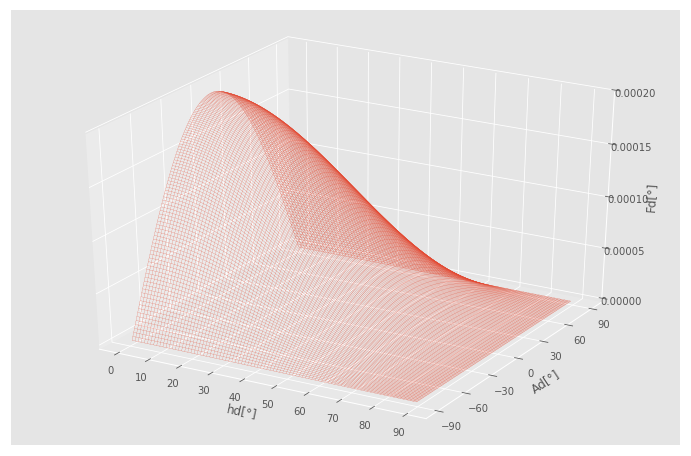

In [10]:
Nd_lat = 90
Nd_lon = 180

dd_F = np.empty((Nd_lat, Nd_lon))
dd_h = np.empty((Nd_lat, Nd_lon))
dd_A = np.empty((Nd_lat, Nd_lon))
dd_phi = np.empty((Nd_lat, Nd_lon))

for l in range(0, Nd_lat):
    for m in range(0, Nd_lon):
        dd_in =dd_input(Nd_lat, Nd_lon, l, m)
        dd_F[l][m] = division_diffuse_ratio(dd_in)[0]   #割合
        dd_h[l][m] = division_diffuse_ratio(dd_in)[1]   #高度角
        dd_A[l][m] = division_diffuse_ratio(dd_in)[2]   #方位角
        dd_phi[l][m] = division_diffuse_ratio(dd_in)[3] #入射角

np.savetxt('3639999_out_hd.csv', dd_h, fmt='%.10f', delimiter=',')
np.savetxt('3639999_out_Ad.csv', dd_A, fmt='%.10f', delimiter=',')
np.savetxt('3639999_out_phid.csv', dd_phi, fmt='%.10f', delimiter=',')
np.savetxt('3639999_out_Fd.csv', dd_F, fmt='%.10f', delimiter=',')
        
#グラフの描画
fig = plt.figure(figsize=(12,8))
plt.style.use('ggplot')

ax1 = fig.gca(projection='3d')
ax1.plot_wireframe(dd_h[0:Nd_lat][0:Nd_lon], dd_A[0:Nd_lat][0:Nd_lon], dd_F[0:Nd_lat][0:Nd_lon], rstride=1, cstride=1, linewidth=0.2)
ax1.set_xticks([10 * i for i in range(10)])
ax1.set_yticks([30 * i - 90 for i in range(7)])
ax1.set_zticks([0.00005 * i for i in range(5)])
ax1.set_xlabel('hd[°]', fontsize = 12)
ax1.set_ylabel('Ad[°]', fontsize = 12)
ax1.set_zlabel('Fd[°]', fontsize = 12)

plt.show()

### 3.2.2. 地表面反射日射

説明：開口部が垂直窓の場合に、地表面反射日射量に対する地表面の任意の微小要素からの地表面反射日射量の割合を計算する。

### 入力値  

$ N_{r,\Phi} $：地表面の緯度方向の分割数  
$ N_{r,L} $：地表面の経度方向の分割数  
$ l $：地表面の緯度方向の$l$番目の分割要素  
$ m $：地表面の経度方向の$m$番目の分割要素

### 出力値

$ F_{r,l,m} $ ：地表面反射日射量に対する地表面上の微小要素からの地表面反射日射量の割合  
$ h_{r,l,m} $：地表面反射日射の微小要素$l,m$における開口面に対する高度角 (°)  
$ A_{r,l,m} $：地表面反射日射の微小要素$l,m$における開口面に対する方位角 (°)  
$ \phi_{r,l,m} $：地表面反射日射の微小要素$l,m$における開口面に対する入射角 (°)  

### 計算方法

#### データ構造と値の範囲

$ N_{r,\Phi} $・$ N_{r,L} $の組み合わせを1つの変数（タプル）で表し"dr_input"とする。  
$ F_{r,l,m} $は0.0以上1.0以下の値をとる。  
$ h_{r,l,m} $は-90°以上、0°以下の値をとる（地平：0°、天頂：-90°）。  
$ A_{r,l,m} $は-90°以上、90°以下の値をとる（東：-90°、南：0°、西：90°）。  
$ \phi_{r,l,m} $は0°以上、90°以下の値をとる（法線方向：0°、接線方向：90°）。

In [11]:
dr_input = namedtuple('dr_input', 'dr_Nlat dr_Nlon dr_l dr_m')
#dr_Nlat：地表面の緯度方向の分割数
#dr_Nlon：地表面の経度方向の分割数
#dr_l：地表面の緯度方向のi番目の分割要素
#dr_m：地表面の経度方向のj番目の分割要素

#### 微小要素からの地表面反射日射の割合の計算

開口部が垂直窓の場合に、地表面反射日射量に対する地表面上の微小要素からの地表面反射日射量の割合$F_{r,l,m}$の計算方法を以下に示す。

$ \begin{align}F_{r,l,m} = \frac{2 ･ \omega_{r,l,m} ･ \cos \phi_{r,l,m}}{\pi}\end{align}$ ･･･････････････････････････ (3.2.2-a)  

$ \begin{align}\omega_{r,l,m} = \cos h_{r,l,m} ･ \frac{\pi}{2 ･ N_{r,lat}} ･ \frac{\pi}{N_{r,lon}}\end{align}$ ････････････････････ (3.2.2-b)  
$ \begin{align}\cos\phi_{r,l,m} = \cos h_{r,l,m} ･ \cos A_{r,l,m}\end{align}$ ････････････････････････ (3.2.2-c)  

$ \begin{align}h_{r,l,m} = \frac{90 ･ (2 ･ l +1)}{2 ･ N_{r,lat}} - 90\end{align}$ ･･･････････････････････････ (3.2.2-d)  

$ \begin{align}A_{r,l,m} = \frac{180 ･ (2 ･ m +1)}{2 ･ N_{r,lon}} - 90\end{align}$ ･･････････････････････････ (3.2.2-e)  

ここで、 

$ \omega_{r,l,m} $：地表面反射日射の微小要素$l,m$における開口面に対する立体角 [sr]  
$ l $：カウンター（0～$N_{r,lat}$ - 1）  
$ m $：カウンター（0～$N_{r,lon}$ - 1）  

である。  

In [12]:
#微小要素からの地表面反射日射の割合の計算
def division_reflect_ratio(L):
    dr_r = np.zeros((4))
    dr_r[1] = 90. * (2. * L.dr_l + 1) / (2. * L.dr_Nlat) - 90.  #高度角
    dr_r[2] = 180. * (2. * L.dr_m + 1) / (2. * L.dr_Nlon) - 90. #方位角
    dr_r[3] = math.degrees(math.acos(abs(math.cos(math.radians(dr_r[1])) * math.cos(math.radians(dr_r[2]))))) #入射角
    dr_omega = math.cos(math.radians(dr_r[1])) * math.pi ** 2. / (2. * L.dr_Nlat * L.dr_Nlon)
    dr_r[0] = 2 * dr_omega * math.cos(math.radians(dr_r[3])) / math.pi #割合
    return dr_r

### 計算例

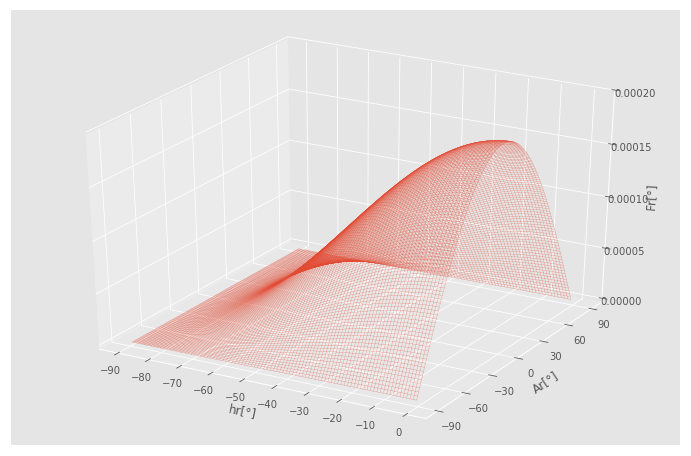

In [13]:
Nr_lat = 90
Nr_lon = 180

dr_F = np.empty((Nr_lat, Nr_lon))
dr_h = np.empty((Nr_lat, Nr_lon))
dr_A = np.empty((Nr_lat, Nr_lon))
dr_phi = np.empty((Nr_lat, Nr_lon))

for l in range(0, Nr_lat):
    for m in range(0, Nr_lon):
        dr_in =dr_input(Nr_lat, Nr_lon, l ,m)
        dr_F[l][m] = division_reflect_ratio(dr_in)[0]   #割合
        dr_h[l][m] = division_reflect_ratio(dr_in)[1]   #高度角
        dr_A[l][m] = division_reflect_ratio(dr_in)[2]   #方位角
        dr_phi[l][m] = division_reflect_ratio(dr_in)[3] #入射角

np.savetxt('3639999_out_hr.csv', dr_h, fmt='%.10f', delimiter=',')
np.savetxt('3639999_out_Ar.csv', dr_A, fmt='%.10f', delimiter=',')
np.savetxt('3639999_out_phir.csv', dr_phi, fmt='%.10f', delimiter=',')
np.savetxt('3639999_out_Fr.csv', dr_F, fmt='%.10f', delimiter=',')
        
#グラフの描画
fig = plt.figure(figsize=(12,8))
plt.style.use('ggplot')

ax1 = fig.gca(projection='3d')
ax1.plot_wireframe(dr_h[0:Nr_lat][0:Nr_lon], dr_A[0:Nr_lat][0:Nr_lon], dr_F[0:Nr_lat][0:Nr_lon], rstride=1, cstride=1, linewidth=0.2)
ax1.set_xticks([10 * i - 90 for i in range(10)])
ax1.set_yticks([30 * i - 90 for i in range(7)])
ax1.set_zticks([0.00005 * i for i in range(5)])
ax1.set_xlabel('hr[°]', fontsize = 12)
ax1.set_ylabel('Ar[°]', fontsize = 12)
ax1.set_zlabel('Fr[°]', fontsize = 12)

plt.show()

### 3.3. 直散分離

説明：水平面全天日射量から水平面天空日射量と法線面直達日射量を計算する。

### 入力値  

$ I_G $ ：水平面全天日射量 [MJ/(m<sup>2</sup>･h)]  
$ h $ ：太陽高度角 (°)  

### 出力値

$ I_b $ ：法線面直達日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_d $ ：水平面天空日射量 [MJ/(m<sup>2</sup>･h)]  

### 計算方法

#### データ構造と値の範囲

$ I_G $・$ h $の組み合わせを1つの変数（タプル）で表し"dbd_input"とする。  
$ h $は0°以上、90°以下の値をとる（ただし、$ h $が3°より小さい場合には、$ h $=3°として計算する）。  

In [14]:
dbd_input = namedtuple('dbd_input', 'dbd_ig dbd_h')
#dbd_ig：水平面全天日射量 [MJ/(m2･h)]  
#dbd_h：太陽高度角 (°) 

#### 直散分離（Watanabe model）の計算

（参考：拡張アメダス気象データ1981-2000解説書 8.2.1　直散分離）  

直散分離（Watanabe model）の計算方法を以下に示す。  

$ \begin{align}I_d = I_0 ･ \sin h ･ \frac{Q}{1 + Q}\end{align}$ ･･････････････････････････････････ (3.3-a)  

$ \begin{align}Q = (0.8672 + 0.7505 ･ \sin h) ･ P ^ {\frac{0.421}{\sin h}} ･ (1 - P ^ {\frac{1}{\sin h}}) ^ {2.277}\end{align}$ ････ (3.3-b)  

大気透過率$ P $は、Bouguer式による。Bouguer式を以下に示す。

$ \begin{align}I_b = I_0 ･ P ^ {\frac{1}{\sin h}}\end{align}$ ･･････････････････････････････････････････ (3.3-c)  

日射の直散成分の関係式を以下に示す。 

$ \begin{align}I_G = I_b ･ \sin h + I_d\end{align}$ ･････････････････････････････････････ (3.3-d)  

ここで、  

$ I_0 $ ：法線面大気外日射量（1367[W/m<sup>2</sup>]=4.9212） [MJ/(m<sup>2</sup>･h)]  
$ P $ ：大気透過率（0 < $ P $ ≦ 0.85）  

である。  

式(3.3-c)、式(3.3-d)を整理すると、式(3.3-e)が得られる。  

$ \begin{align}I_d = I_G - I_0 ･ P ^ {\frac{1}{\sin h}} ･ \sin h\end{align}$ ･･･････････････････････････････ (3.3-e)  

大気透過率$ P $及び水平面天空日射量$I_d$は、式(3.3-a)と式(3.3-e)から収束計算によって求める。  

法線面直達日射量$I_b$は、式(3.3-d)を変形した式(3.3-f)から求める。  

$ \begin{align}I_b = \frac{I_G - I_d}{\sin h}\end{align}$ ･･････････････････････････････････････････ (3.3-f)  

In [15]:
#直散分離（Watanabe model）の計算
def division_beam_diffuse(L):
    dbd_r = np.zeros(2)
    #dbd_r[0]：法線面直達日射量
    #dbd_r[1]：水平面天空日射量
    dbd_i0 = 4.9212 #法線面大気外日射量(MJ/(m2h))
    if 0. < L.dbd_h and L.dbd_h < 3.:
        dbd_sinh =  math.sin(math.radians(3.)) #太陽高度角の補正
    elif 3. < L.dbd_h and L.dbd_h <= 90.:
        dbd_sinh =  math.sin(math.radians(L.dbd_h))
    else:
        dbd_sinh = 0.
        
    def f_id(dbd_px):
        dbd_q = (0.8672 + 0.7505 * dbd_sinh) * dbd_px ** (0.421 / dbd_sinh) * (1. - dbd_px ** (1. / dbd_sinh)) ** 2.277
        dbd_id1 = dbd_i0 * dbd_sinh * dbd_q / (1 + dbd_q)
        dbd_id2 = L.dbd_ig - dbd_i0 * dbd_px ** (1 / dbd_sinh) * dbd_sinh
        return dbd_id1 - dbd_id2
    
    #収束計算(二分法)
    p_min = 0. #初期値(下限)
    p_max = 1. #初期値(上限)
    p_cnt = 0  #繰り返し回数
    if dbd_sinh > 0. and L.dbd_ig > 0.:
        while True:
            p_cnt += 1
            dbd_p = (p_min + p_max) / 2.
            if f_id(p_min) * f_id(dbd_p) < 0.:
                p_max = dbd_p
            else:
                p_min = dbd_p
            if abs (f_id(dbd_p)) < 10. ** (-10.):
                if dbd_p > 0.85:
                    dbd_p = 0.85
                break
            elif p_cnt > 10. ** 3.:
                dbd_p = 99999.
                break
     
        if dbd_p != 99999.:
            #法線面直達日射量
            dbd_r[0] = dbd_i0 * dbd_p ** (1 / dbd_sinh)
            if dbd_r[0] > 4.18:
                dbd_r[0] = 4.18
            #水平面天空日射量
            dbd_r[1] = L.dbd_ig - dbd_r[0] * dbd_sinh
            if dbd_r[1] < 0.:
                dbd_r[1] = 0.            
        else:
            dbd_r[0] = 99999.
            dbd_r[1] = 99999.
    else:
        dbd_r[0] = 0.
        dbd_r[1] = 0.
    return dbd_r

### 計算例

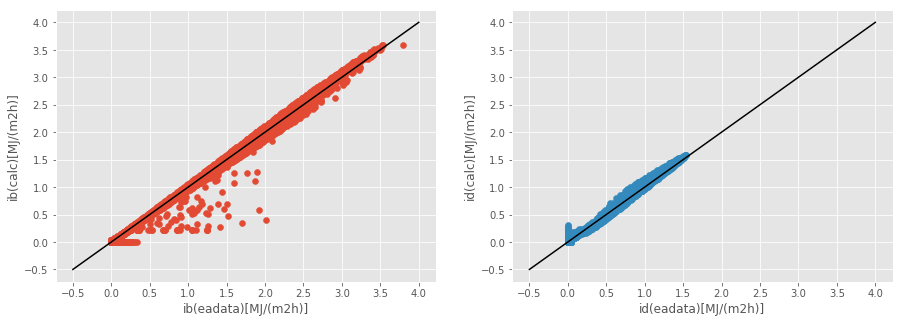

In [16]:
dbd_result = np.empty((5,8760))

for i in range(0, 8760):
    dbd_in = dbd_input(ig[i], sp_result[3][i])
    dbd_result[0][i] = i + 1.                                           #年通算時間
    dbd_result[1][i] = int((i + 1.) / 24.) + 1.                         #年通算日
    dbd_result[2][i] = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.     #時刻
    dbd_result[3][i] = division_beam_diffuse(dbd_in)[0]                 #法線面直達日射量
    dbd_result[4][i] = division_beam_diffuse(dbd_in)[1]                 #水平面天空日射量
    
np.savetxt('3639999_out_dbd.csv', np.transpose(dbd_result), fmt='%.10f', delimiter=',')

#グラフの描画
fig = plt.figure(figsize=(15,5))
plt.style.use('ggplot')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ib_ea[0:8760], dbd_result[3][0:8760], color = 'C0') #法線面直達日射量の比較
ax1.plot([-0.5,4.],[-0.5,4.], color = (0,0,0))
ax1.set_xticks([0.5 * (i-1) for i in range(10)])
ax1.set_yticks([0.5 * (i-1) for i in range(10)])
ax1.set_xlabel('ib(eadata)[MJ/(m2h)]', fontsize = 12)
ax1.set_ylabel('ib(calc)[MJ/(m2h)]', fontsize = 12)

ax2.scatter(id_ea[0:8760], dbd_result[4][0:8760], color = 'C1') #水平面天空日射量の比較
ax2.plot([-0.5,4.],[-0.5,4.], color = (0,0,0))
ax2.set_xticks([0.5 * (i-1) for i in range(10)])
ax2.set_yticks([0.5 * (i-1) for i in range(10)])
ax2.set_xlabel('id(eadata)[MJ/(m2h)]', fontsize = 12)
ax2.set_ylabel('id(calc)[MJ/(m2h)]', fontsize = 12)

plt.show()

### 3.4. 斜面（開口面）日射量（Isotropic model）

説明：水平面全天日射量・水平面天空日射量・法線面直達日射量から斜面（開口面）日射量（直達・天空・地表面反射）を計算する。

### 入力値  

$ I_G $ ：水平面全天日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_b $ ：法線面直達日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_d $ ：水平面天空日射量 [MJ/(m<sup>2</sup>･h)]  
$ h $ ：太陽高度角 (°)  
$ A $ ：太陽方位角 (°)  
$ \beta $ ：水平面に対する斜面（開口面）の傾斜角 (°)  
$ A_w $ ：斜面（開口面）の方位角 (°)  
$ \rho $ ：アルベド  

### 出力値

$ I_{T,b} $ ：斜面（開口面）直達日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_{T,d} $ ：斜面（開口面）天空日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_{T,r} $ ：斜面（開口面）地表面反射日射量 [MJ/(m<sup>2</sup>･h)]  
$ \phi $ ：直達日射の入射角 (°)  

### 計算方法

#### データ構造と値の範囲

$ I_G $・$ I_d $・$ I_b $・$ h $・$ A $・$ \beta $・$ A_w $・$ \rho $の組み合わせを1つの変数（タプル）で表し"st_input"とする。  
$ h $は0°以上、90°以下の値をとる。  
$ \rho $は0.0以上、1.0以下の値をとる。

In [17]:
st_input = namedtuple('st_input', 'st_ig st_ib st_id st_h st_A st_Bw st_Aw st_rho')
#st_ig：水平面全天日射量 [MJ/(m2･h)]  
#st_ib：法線面直達日射量 [MJ/(m2･h)]  
#st_id：水平面天空日射量 [MJ/(m2･h)]  
#st_h：太陽高度角 (°) 
#st_A：太陽方位角 (°)  
#st_Bw：水平面に対する斜面（開口面）の傾斜角 (°)  
#st_Aw：斜面（開口面）の方位角 (°)  
#st_rho：アルベド

#### 斜面（開口面）日射量（Isotropic model）の計算

（参考：拡張アメダス気象データ1981-2000解説書 8.2.2　斜面日射量の計算）  

斜面（開口面）日射量（Isotropic model）の計算方法を以下に示す。  

$ \begin{align}I_{T,b} = I_b ･ \cos \phi\end{align}$ ････････････････････････････････････････････ (3.4-a)  

$ \begin{align}I_{T,d} = I_d ･ \frac{1 + \cos\beta}{2}\end{align}$ ････････････････････････････････････････ (3.4-b)  

$ \begin{align}I_{T,r} = I_G ･ \frac{1 - \cos\beta}{2} ･ \rho\end{align}$ ･･････････････････････････････････････ (3.4-c)  

$ \begin{align}\cos \phi = \sin h ･ \cos \beta + \cos h ･ \sin \beta ･ \cos (A-A_w)\end{align}$ ･････････････ (3.4-d)  


In [18]:
#斜面（開口面）日射量（Isotropic model）の計算
def solor_tilt(L):
    st_r = np.zeros((4))
    #st_r[0]：斜面（開口面）直達日射量
    #st_r[1]：斜面（開口面）天空日射量
    #st_r[2]：斜面（開口面）地表面反射日射量
    #st_r[3]：直達日射の入射角
    if 0. < L.st_h and L.st_h < 3.:
        st_sinh =  math.sin(math.radians(3.)) #太陽高度角の補正
        st_cosh =  math.cos(math.radians(3.)) #太陽高度角の補正
    elif 3. < L.st_h and L.st_h < 90.:
        st_sinh =  math.sin(math.radians(L.st_h))
        st_cosh =  math.cos(math.radians(L.st_h))
    else:
        st_sinh =  0.
        st_cosh =  1.
            
    if st_sinh > 0. and L.st_ig > 0.:
        st_cosphi = abs(st_sinh * math.cos(math.radians(L.st_Bw)) + st_cosh * math.sin(math.radians(L.st_Bw)) * math.cos(math.radians(L.st_A - L.st_Aw)))
        st_r[0] = L.st_ib * st_cosphi
        st_r[1] = L.st_id * (1 + math.cos(math.radians(L.st_Bw))) / 2
        st_r[2] = L.st_ig * (1 - math.cos(math.radians(L.st_Bw))) / 2 * L.st_rho
        st_r[3] = math.degrees(math.acos(st_cosphi))
    else:
        st_r[0] = 0.
        st_r[1] = 0.
        st_r[2] = 0.
        st_r[3] = 0.
    return st_r

### 計算例

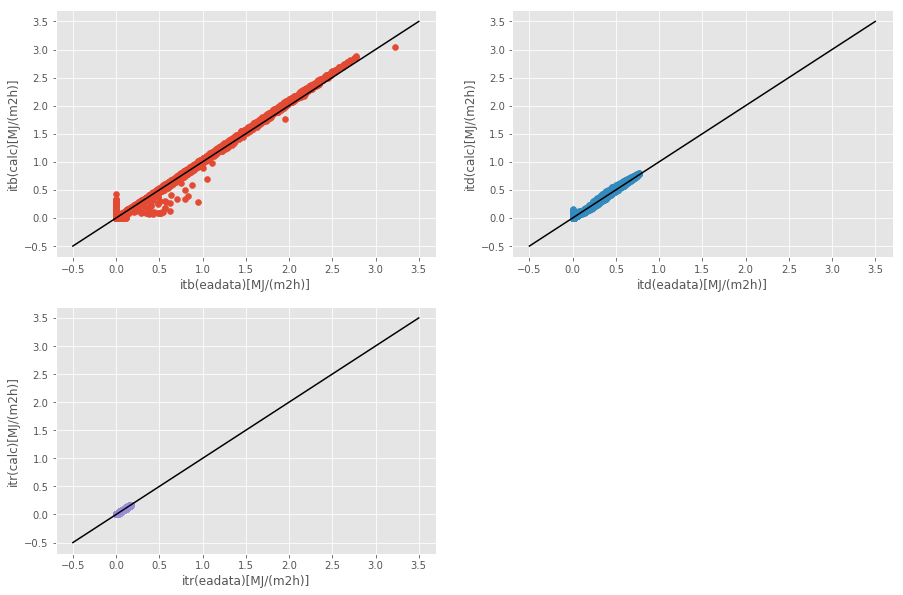

In [19]:
st_result = np.empty((7,8760))

for i in range(0, 8760):
    st_in = st_input(ig[i], dbd_result[3][i], dbd_result[4][i], sp_result[3][i], sp_result[4][i], 90, 0, 0.1)
    st_result[0][i] = i + 1.                                           #年通算時間
    st_result[1][i] = int((i + 1.) / 24.) + 1.                         #年通算日
    st_result[2][i] = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.    #時刻
    st_result[3][i] = solor_tilt(st_in)[0]                             #斜面（開口面）直達日射量
    st_result[4][i] = solor_tilt(st_in)[1]                             #斜面（開口面）天空日射量
    st_result[5][i] = solor_tilt(st_in)[2]                             #斜面（開口面）地表面反射日射量
    st_result[6][i] = solor_tilt(st_in)[3]                             #直達日射の入射角
    
np.savetxt('3639999_out_st.csv', np.transpose(st_result), fmt='%.10f', delimiter=',')

#グラフの描画
fig = plt.figure(figsize=(15,10))
plt.style.use('ggplot')

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

ax1.scatter(itb_ea[0:8760], st_result[3][0:8760], color = 'C0')        #斜面直達日射量の比較
ax1.plot([-0.5,3.5],[-0.5,3.5], color = (0,0,0))
ax1.set_xticks([0.5 * (i-1) for i in range(9)])
ax1.set_yticks([0.5 * (i-1) for i in range(9)])
ax1.set_xlabel('itb(eadata)[MJ/(m2h)]', fontsize = 12)
ax1.set_ylabel('itb(calc)[MJ/(m2h)]', fontsize = 12)

ax2.scatter(itd_ea[0:8760], st_result[4][0:8760], color = 'C1')        #斜面天空日射量の比較
ax2.plot([-0.5,3.5],[-0.5,3.5], color = (0,0,0))
ax2.set_xticks([0.5 * (i-1) for i in range(9)])
ax2.set_yticks([0.5 * (i-1) for i in range(9)])
ax2.set_xlabel('itd(eadata)[MJ/(m2h)]', fontsize = 12)
ax2.set_ylabel('itd(calc)[MJ/(m2h)]', fontsize = 12)

ax3.scatter(itr_ea[0:8760], st_result[5][0:8760], color = 'C2')        #斜面地表面反射日射量の比較
ax3.plot([-0.5,3.5],[-0.5,3.5], color = (0,0,0))
ax3.set_xticks([0.5 * (i-1) for i in range(9)])
ax3.set_yticks([0.5 * (i-1) for i in range(9)])
ax3.set_xlabel('itr(eadata)[MJ/(m2h)]', fontsize = 12)
ax3.set_ylabel('itr(calc)[MJ/(m2h)]', fontsize = 12)

plt.show()

## 4. ひさしの日除け計算  

## 5. 窓の日射熱取得率の計算 

### 5.1. グレージング複合体の日射熱取得率  

### 5.1.1. 面材の光学特性

### 5.1.1.1. ガラス

説明：垂直入射時のガラスの日射透過率及び日射反射率から任意の入射角におけるガラスの日射透過率及び日射反射率を計算する。

### 入力値  

$ \tau_{0,f} $ ：ガラスの正面側からの入射光に対する垂直入射時の日射透過率  
$ \tau_{0,b} $ ：ガラスの背面側からの入射光に対する垂直入射時の日射透過率  
$ \rho_{0,f} $ ：ガラスの正面側からの入射光に対する垂直入射時の日射反射率  
$ \rho_{0,b} $ ：ガラスの背面側からの入射光に対する垂直入射時の日射反射率  
$ \phi $       ：日射の入射角（°）  
gtype          ：ガラスの種類flag（0：透明フロート板ガラス、1：Low-Eガラス）  
ctypef         ：正面側の膜の有無flag（0：膜なし、1：膜あり）  
ctypeb         ：背面側の膜の有無flag（0：膜なし、1：膜あり）  

### 出力値

$ \tau_{\phi,f} $ ：ガラスの正面側からの入射光に対する入射角$\phi$の日射透過率  
$ \tau_{\phi,b} $ ：ガラスの背面側からの入射光に対する入射角$\phi$の日射透過率  
$ \rho_{\phi,f} $ ：ガラスの正面側からの入射光に対する入射角$\phi$の日射反射率  
$ \rho_{\phi,b} $ ：ガラスの背面側からの入射光に対する入射角$\phi$の日射反射率

### 計算方法

#### データ構造と値の範囲

$\tau_{0,f}$・$\tau_{0,b}$・$\rho_{0,f}$・$\rho_{0,b}$・$ \phi $・gtype・ctypef・ctypebの組み合わせを1つの変数（タプル）で表し"glass_input"とする。  
全ての値は0.0以上1.0以下の値をとる。  
$\tau_{0,f}$ と $\rho_{0,f}$ の合計は1.0を超えない。  
$\tau_{0,b}$ と $\rho_{0,b}$ の合計は1.0を超えない。  
$\phi$は0°以上、90°以下の値をとる。 

In [20]:
glass_input = namedtuple('glass_input','glass_TRS0f glass_TRS0b glass_REF0f glass_REF0b glass_phi glass_gtype glass_ctypef glass_ctypeb')
# glass_TRS0f：正面側からの入射光に対する垂直入射時の日射透過率
# glass_TRS0f：正面側からの入射光に対する垂直入射時の日射透過率
# glass_TRS0b：背面側からの入射光に対する垂直入射時の日射透過率
# glass_REF0f：正面側からの入射光に対する垂直入射時の日射反射率
# glass_REF0b：背面側からの入射光に対する垂直入射時の日射反射率
# glass_phi：日射の入射角（°）
# glass_gtype：ガラスの種類flag（0：透明フロート板ガラス、1：Low-Eガラス）
# glass_ctypef：正面側の膜の有無flag（0：膜なし、1：膜あり）
# glass_ctypeb：背面側の膜の有無flag（0：膜なし、1：膜あり）

#### 入射角$\phi$の日射透過率及び日射反射率の計算  

（参考：JIS A 2103：2014 附属書G 斜入射に対する板ガラスの光学特性の計算方法）  

入射角によって日射特性が変化するガラスの日射透過率及び日射反射率の計算方法を以下に示す。  

$ \begin{align}\tau_{\phi,f} = \tau_{0,f}･\sum_{i=0}^5 m_{i}･\cos^i\phi\end{align} $ ･････････････････････････････ (5.1.1.1-a)

$ \begin{align}\tau_{\phi,b} = \tau_{0,b}･\sum_{i=0}^5 m_{i}･\cos^i\phi\end{align} $ ･････････････････････････････ (5.1.1.1-b)

$ \begin{align}\rho_{\phi,f} =\rho_{0,f}+(1-\rho_{0,f})･\sum_{i=0}^5 m_{i}･\cos^i\phi\end{align} $ ･････････････････ (5.1.1.1-c)

$ \begin{align}\rho_{\phi,b} =\rho_{0,b}+(1-\rho_{0,b})･\sum_{i=0}^5 m_{i}･\cos^i\phi\end{align} $ ･････････････････ (5.1.1.1-d)  

ここで、  

$ m_{i} $ ：ガラス種類ごとの係数  

である。

$ m_{i} $ の係数表を以下に示す（参考：JIS A 2103：2014 表G.1）。なお、本仕様書では透明フロート板ガラス及びLow-Eガラスのみについてプログラムを記述する。  

| 板ガラス品種分類              | 規準化透過率又は規準化反射率 | $m_0$ | $m_1$ | $m_2$ | $m_3$ | $m_4$ | $m_5$ |
| :---                      | :---                         | ---: | ---: | ---: | ---: | ---: | ---: |
| 透明フロート板ガラス            | 規準化透過率                 | 0.000 | 2.552 | 1.364 | -11.388 | 13.617 | -5.146 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.189 | 12.392 | -16.593 | 11.851 | -3.461 |
| 熱線吸収板ガラス              | 規準化透過率                 | 0.000 | 1.760 | 3.770 | -14.901 | 16.422 | -6.052 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.189 | 12.392 | -16.593 | 11.851 | -3.461 |
| 熱線反射ガラス                | 規準化透過率                 | 0.000 | 3.297 | -1.122 | -8.408 | 12.206 | -4.972 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.842 | 15.264 | -21.642 | 15.948 | -4.727 |
|                               | 規準化反射率(膜面)           | 1.000 | -5.842 | 15.264 | -21.642 | 15.948 | -4.727 |
| 熱線吸収熱線反射ガラス        | 規準化透過率                 | 0.000 | 2.558 | 0.989 | -11.214 | 14.275 | -5.608 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.842 | 15.264 | -21.642 | 15.948 | -4.727 |
|                               | 規準化反射率(膜面)           | 1.000 | -5.842 | 15.264 | -21.642 | 15.948 | -4.727 |
| 高性能熱線反射ガラスSシリーズ | 規準化透過率                 | 0.000 | 5.342 | -10.170 | 6.670 | 0.886 | -1.728 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -6.459 | 18.722 | -28.982 | 22.804 | -7.085 |
|                               | 規準化反射率(膜面)           | 1.000 | -9.187 | 33.681 | -59.593 | 50.413 | -16.314 |
| 高性能熱線反射ガラスTシリーズ | 規準化透過率                 | 0.000 | 2.552 | 1.364 | -11.388 | 13.617 | -5.146 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.782 | 14.816 | -20.567 | 14.862 | -4.331 |
|                               | 規準化反射率(膜面)           | 1.000 | -8.900 | 31.953 | -55.934 | 47.050 | -15.176 |
| Low-Eガラス                    | 規準化透過率                 | 0.000 | 2.273 | 1.631 | -10.358 | 11.769 | -4.316 |
|                               | 規準化反射率(ガラス面)       | 1.000 | -5.084 | 12.646 | -18.213 | 13.967 | -4.316 |
|                               | 規準化反射率(膜面)           | 1.000 | -4.387 | 9.175 | -11.152 | 7.416 | -2.052 |

In [21]:
# 入射角φの日射透過率及び日射反射率の計算
def glass_TRSf(L):
    glass_TRSnf = 0.
    for i in range(0, 6):
        glass_TRSnf += glass_mTRS(L)[i] * math.cos(math.radians(L.glass_phi)) ** i
    return L.glass_TRS0f * glass_TRSnf

def glass_TRSb(L):
    glass_TRSnb = 0.
    for i in range(0, 6):
        glass_TRSnb += glass_mTRS(L)[i] * math.cos(math.radians(L.glass_phi)) ** i
    return L.glass_TRS0b * glass_TRSnb
    
def glass_REFf(L):
    glass_REFnf = 0.
    for i in range(0, 6):
        if L.glass_ctypef == 0:
            glass_REFnf += glass_mREFg(L)[i] * math.cos(math.radians(L.glass_phi)) ** i
        elif L.glass_ctypef == 1:
            glass_REFnf += glass_mREFc(L)[i] * math.cos(math.radians(L.glass_phi)) ** i
    return L.glass_REF0f + (1 - L.glass_REF0f) * glass_REFnf
    
def glass_REFb(L):
    glass_REFnb = 0.0
    for i in range(0, 6):
        if L.glass_ctypeb == 0:
            glass_REFnb += glass_mREFg(L)[i] * math.cos(math.radians(L.glass_phi)) ** i
        elif L.glass_ctypeb == 1:
            glass_REFnb += glass_mREFc(L)[i] * math.cos(math.radians(L.glass_phi)) ** i
    return L.glass_REF0b + (1 - L.glass_REF0b) * glass_REFnb

#係数mの選択。ここでは、透明フロート板ガラス及びLow-Eガラスのみを記述する。
def glass_mTRS(L):
    if L.glass_gtype == 0:    return [0.000, 2.552, 1.364, -11.388, 13.617, -5.146]
    elif L.glass_gtype == 1:  return [0.000, 2.273, 1.631, -10.358, 11.769, -4.316]
    else:                         return ValueError

def glass_mREFg(L):
    if L.glass_gtype == 0:    return [1.000, -5.189, 12.392, -16.593, 11.851, -3.461]
    elif L.glass_gtype == 1:  return [1.000, -5.084, 12.646, -18.213, 13.967, -4.316]
    else:                   return ValueError

def glass_mREFc(L):
    if L.glass_gtype == 0:    return ValueError
    elif L.glass_gtype == 1:  return [1.000, -4.387, 9.175, -11.152, 7.416, -2.052]
    else:                   return ValueError

### 計算例

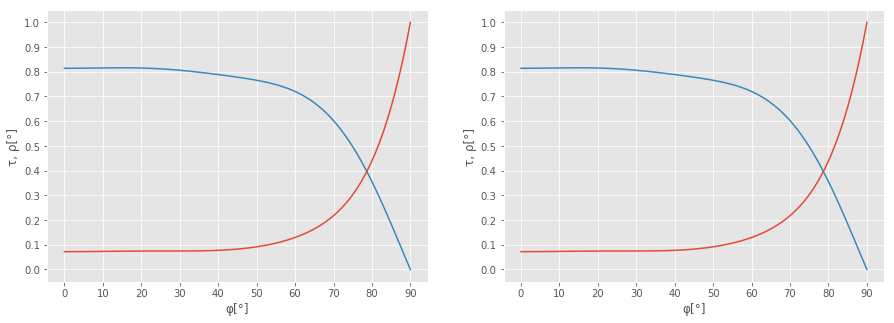

In [22]:
glass_result = np.zeros((5,91))

for j in range(0, 91):
    gl_in = glass_input(0.815, 0.815, 0.072, 0.072, j, 0, 0, 0)
    glass_result[0][j] = j
    glass_result[1][j] = glass_TRSf(gl_in)
    glass_result[2][j] = glass_TRSb(gl_in)
    glass_result[3][j] = glass_REFf(gl_in)
    glass_result[4][j] = glass_REFb(gl_in)
   
np.savetxt('glass_result.csv', np.transpose(glass_result), fmt='%.10f', delimiter=',')

#グラフの描画
fig = plt.figure(figsize=(15,5))
plt.style.use('ggplot')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(glass_result[0][0:91], glass_result[1][0:91], color = 'C1') #ガラスの斜入射透過率(正面側)
ax1.plot(glass_result[0][0:91], glass_result[3][0:91], color = 'C0') #ガラスの斜入射反射率(正面側)
ax1.set_xticks([10 * i for i in range(10)])
ax1.set_yticks([0.1 * i for i in range(11)])
ax1.set_xlabel('φ[°]', fontsize = 12)
ax1.set_ylabel('τ, ρ[°]', fontsize = 12)

ax2.plot(glass_result[0][0:91], glass_result[2][0:91], color = 'C1') #ガラスの斜入射透過率(背面側)
ax2.plot(glass_result[0][0:91], glass_result[4][0:91], color = 'C0') #ガラスの斜入射反射率(背面側)
ax2.set_xticks([10 * i for i in range(10)])
ax2.set_yticks([0.1 * i for i in range(11)])
ax2.set_xlabel('φ[°]', fontsize = 12)
ax2.set_ylabel('τ, ρ[°]', fontsize = 12)

plt.show()

### 5.1.1.2. ロールスクリーン

説明：垂直入射時のロールスクリーンの日射透過率及び日射反射率から任意の入射角におけるロールスクリーンの日射透過率及び日射反射率を計算する。

### 入力値  
$ \tau_{0,f} $ ：ロールスクリーンの正面側からの入射光に対する垂直入射時の日射透過率  
$ \tau_{0,b} $ ：ロールスクリーンの背面側からの入射光に対する垂直入射時の日射透過率  
$ \rho_{0,f} $ ：ロールスクリーンの正面側からの入射光に対する垂直入射時の日射反射率  
$ \rho_{0,b} $ ：ロールスクリーンの背面側からの入射光に対する垂直入射時の日射反射率  
$ \phi$        ：日射の入射角（°）

### 出力値
$ \tau_{\phi,f} $ ：ロールスクリーンの正面側からの入射光に対する入射角$\phi$の日射透過率  
$ \tau_{\phi,b} $ ：ロールスクリーンの背面側からの入射光に対する入射角$\phi$の日射透過率  
$ \rho_{\phi,f} $ ：ロールスクリーンの正面側からの入射光に対する入射角$\phi$の日射反射率  
$ \rho_{\phi,b} $ ：ロールスクリーンの背面側からの入射光に対する入射角$\phi$の日射反射率

### 計算方法  

#### データ構造と値の範囲  

$\tau_{0,f}$・$\tau_{0,b}$・$\rho_{0,f}$・$\rho_{0,b}$の組み合わせを1つの変数（タプル）で表し"role_input"とする。  
全ての値は0.0以上1.0以下の値をとる。  
$\tau_{0,f}$ と $\rho_{0,f}$ の合計は1.0を超えない。  
$\tau_{0,b}$ と $\rho_{0,b}$ の合計は1.0を超えない。  
$\phi$は0°以上、90°以下の値をとる。  

In [23]:
role_input = namedtuple('role_input','role_TRS0f role_TRS0b role_REF0f role_REF0b role_phi')
# role_TRS0f：正面側からの入射光に対する垂直入射時の日射透過率
# role_TRS0b：背面側からの入射光に対する垂直入射時の日射透過率
# role_REF0f：正面側からの入射光に対する垂直入射時の日射反射率
# role_REF0b：背面側からの入射光に対する垂直入射時の日射反射率
# role_phi：日射の入射角（°）

#### 入射角φの日射透過率及び日射反射率の計算

入射角によって日射特性が変化しないロールスクリーンの日射透過率及び日射反射率の計算方法を以下に示す。  

$ \begin{align}\tau_{\phi,f} = \tau_{0,f}\end{align}$ ････････････････････････････････････････････ (5.1.1.2-a)

$ \begin{align}\tau_{\phi,b} = \tau_{0,b}\end{align}$ ････････････････････････････････････････････ (5.1.1.2-b)

$ \begin{align}\rho_{\phi,f} =\rho_{0,f}\end{align}$ ････････････････････････････････････････････ (5.1.1.2-c)

$ \begin{align}\rho_{\phi,b} =\rho_{0,b}\end{align}$ ････････････････････････････････････････････ (5.1.1.2-d)  

In [24]:
# 入射角φの日射透過率及び日射反射率の計算
def role_TRSf(L):
    return L.role_TRS0f

def role_TRSb(L):
    return L.role_TRS0b
    
def role_REFf(L):
    return L.role_REF0f
    
def role_REFb(L):
    return L.role_REF0b

### 計算例

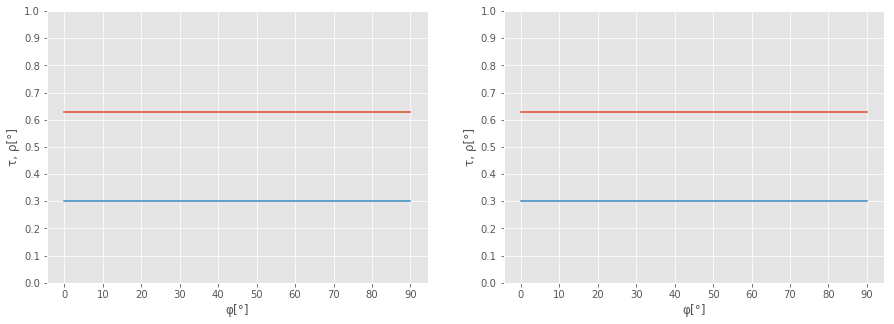

In [25]:
role_result = np.zeros((5,91))

for j in range(0, 91):
    rl_in = role_input(0.3, 0.3, 0.63, 0.63, j)
    role_result[0][j] = j
    role_result[1][j] = role_TRSf(rl_in)
    role_result[2][j] = role_TRSb(rl_in)
    role_result[3][j] = role_REFf(rl_in)
    role_result[4][j] = role_REFb(rl_in)
   
np.savetxt('role_result.csv', np.transpose(role_result), fmt='%.10f', delimiter=',')

#グラフの描画
fig = plt.figure(figsize=(15,5))
plt.style.use('ggplot')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(role_result[0][0:91], role_result[1][0:91], color = 'C1') #ロールスクリーンの斜入射透過率(正面側)
ax1.plot(role_result[0][0:91], role_result[3][0:91], color = 'C0') #ロールスクリーンの斜入射反射率(正面側)
ax1.set_xticks([10 * i for i in range(10)])
ax1.set_yticks([0.1 * i for i in range(11)])
ax1.set_xlabel('φ[°]', fontsize = 12)
ax1.set_ylabel('τ, ρ[°]', fontsize = 12)

ax2.plot(role_result[0][0:91], role_result[2][0:91], color = 'C1') #ロールスクリーンの斜入射透過率(背面側)
ax2.plot(role_result[0][0:91], role_result[4][0:91], color = 'C0') #ロールスクリーンの斜入射反射率(背面側)
ax2.set_xticks([10 * i for i in range(10)])
ax2.set_yticks([0.1 * i for i in range(11)])
ax2.set_xlabel('φ[°]', fontsize = 12)
ax2.set_ylabel('τ, ρ[°]', fontsize = 12)

plt.show()

### 5.1.1.3. ブラインド

### 5.1.1.3.1. 幾何学形状の作成

### 5.1.1.3.2. 鏡面反射成分の計算

### 5.1.1.3.3. 拡散反射成分の計算

### 5.1.1.3.4. 全体計算

### 5.1.2. 短波長放射（日射）の多重反射 

説明：グレージング・日除け・付属部材等の各層において、短波長日射の正面（室外）側からの透過率、背面（室内）側からの透過率、正面側からの反射率、背面側からの反射率が既知の場合に、短波長の多重反射を解いて、グレージング複合体全体の透過率および、各層で吸収される短波長の吸収率を計算する。  
添え字$i$、$j$は層の番号（0～$n$-1）であり、$n$は層の数を表す。

### 入力値  
$ \tau_{f,j} $ ：層$j$の正面側からの入射光に対する日射透過率  
$ \tau_{b,j} $ ：層$j$の背面側からの入射光に対する日射透過率  
$ \rho_{f,j} $ ：層$j$の正面側からの入射光に対する日射反射率  
$ \rho_{b,j} $ ：層$j$の背面側からの入射光に対する日射反射率

### 出力値  

$ \tau_{glz} $ ：グレージング複合体全体の透過率  
$ \alpha_j $ ：層$j$の正面側からの入射光に対する日射吸収率  

### 計算方法  

#### 層$j$のデータ構造と値の範囲

層1つにつき、$\tau_f$・$\tau_b$・$\rho_f$・$\rho_b$の組み合わせを1つの変数（タプル）で表し"layer"とする。  
全ての値は0.0以上1.0以下の値をとる。  
$\tau_f$ と $\rho_f$ の合計は1.0を超えない。  
$\tau_b$ と $\rho_b$ の合計は1.0を超えない。  

In [26]:
layer_input = namedtuple('layer_input','ly_TRSf ly_TRSb ly_REFf ly_REFb')
# ly_TRSf：正面側からの入射光に対する日射透過率
# ly_TRSf：正面側からの入射光に対する日射透過率
# ly_TRSb：背面側からの入射光に対する日射透過率
# ly_REFf：正面側からの入射光に対する日射反射率
# ly_REFb：背面側からの入射光に対する日射反射率

#### 任意の層から任意の層までの多重反射計算  

（参考：JIS A 2103：2014 5.4.2 日射透過率及び各面材の日射吸収率）

隣り合う層$i$から層$j$までの値の計算方法を以下に示す。  

$ \begin{align}\tau_{f,i,j} = \frac {\tau_{f,i,j-1}･\tau_{f,j}}{1-\rho_{b,i,j-1}･\rho_{f,j}}\end{align}$ ････････････････････････････････ (5.1.2-a)

$ \begin{align}\tau_{b,i,j} = \frac {\tau_{b,j}･\tau_{b,i,j-1}}{1-\rho_{b,i,j-1}･\rho_{f,j}}\end{align}$ ････････････････････････････････ (5.1.2-b)

$ \begin{align}\rho_{f,i,j} = \rho_{f,i,j-1} + \frac {\tau_{f,i,j-1}･\rho_{f,j}･\tau_{b,i,j-1}}{1-\rho_{b,i,j-1}･\rho_{f,j}}\end{align}$ ･････････････････････ (5.1.2-c)

$ \begin{align}\rho_{b,i,j} = \rho_{b,j} + \frac {\tau_{b,j}･\rho_{b,i,j-1}･\tau_{f,j}}{1-\rho_{b,i,j-1}･\rho_{f,j}}\end{align}$ ･･････････････････････････ (5.1.2-d)

ここで、

$ \tau_{f,i,j} $　：　層$i$－$j$間の正面側からの入射光に対する日射透過率  
$ \tau_{b,i,j} $　：　層$i$－$j$間の背面側からの入射光に対する日射透過率  
$ \rho_{f,i,j} $　：　層$i$－$j$間の正面側からの入射光に対する日射反射率  
$ \rho_{b,i,j} $　：　層$i$－$j$間の背面側からの入射光に対する日射反射率  

である。  

任意の層$i$－$j$間の値を求める場合は、層$i+1$, $i+2$,..., $j-2$, $j-1$, $j$というように、式(5.1.2-a)～式(5.1.2-d)を逐次代入して求める。  

ここで、$ i=j $ のときは、

$ \begin{align}\tau_{f,i,j} = \tau_{f,j}\end{align} $ ････････････････････････････････････････････ (5.1.2-e)

$ \begin{align}\tau_{b,i,j} = \tau_{b,j}\end{align} $ ････････････････････････････････････････････ (5.1.2-f)

$ \begin{align}\rho_{f,i,j} = \rho_{f,j}\end{align} $ ････････････････････････････････････････････ (5.1.2-g)

$ \begin{align}\rho_{b,i,j} = \rho_{b,j}\end{align} $ ････････････････････････････････････････････ (5.1.2-h)

である。

In [27]:
# 層riから層rjの複合した、TRSf TRSb REFf REFb を算出する。
def Sol_Multi_Lay(L, ri, rj):
    
    # riとrjの数値の範囲に関するエラー処理
    if ri <  0:      raise ValueError
    if rj <  0:      raise ValueError
    if ri >  rj:     raise ValueError
    if rj >= len(L): raise ValueError

    if ri == rj:
        return L[rj]
    else:
        SML = Sol_Multi_Lay(L, ri, rj-1) #層1から層j-1の日射特性値
        trsf = (SML.ly_TRSf * L[rj].ly_TRSf) / (1. - SML.ly_REFb * L[rj].ly_REFf)
        trsb = (L[rj].ly_TRSb * SML.ly_TRSb) / (1. - SML.ly_REFb * L[rj].ly_REFf)
        reff = SML.ly_REFf + (SML.ly_TRSf * L[rj].ly_REFf * SML.ly_TRSb) / (1. - SML.ly_REFb * L[rj].ly_REFf)
        refb = L[rj].ly_REFb + (L[rj].ly_TRSb * SML.ly_REFb * L[rj].ly_TRSf) / (1. - SML.ly_REFb * L[rj].ly_REFf)
        return layer_input(trsf, trsb, reff, refb)

#### 各層の日射吸収率

（参考：JIS A 2103：2014 5.4.2 日射透過率及び各面材の日射吸収率）

各層の値の計算方法を以下に示す。  
（JISでは添え字は1始まりであるが、本仕様書では0始まりとしている。） 

$ j = 0 $ かつ $ n = 0 $ の場合

$ \begin{align} \alpha_j = \alpha_{f,j} \end{align} $ ･･････････････････････････････････････････････ (5.1.2-i)

$ j = 0 $ かつ $ n ≠ 0 $ の場合

$ \begin{align} \alpha_j = \alpha_{f,j} + \frac {\tau_{f,0,j}･\rho_{f,j+1,n}}{1-\rho_{b,0,j}･\rho_{f,j+1,n}}･\alpha_{b,j} \end{align} $ ･･････････････････････ (5.1.2-j)

$ j = 1 $～$ n - 2 $ の場合  

$ \begin{align} \alpha_j = \frac {\tau_{f,0,j-1}}{1-\rho_{b,0,j-1}･\rho_{f,j,n}}･\alpha_{f,j} + \frac {\tau_{f,0,j}･\rho_{f,j+1,n}}{1-\rho_{b,0,j}･\rho_{f,j+1,n}}･\alpha_{b,j} \end{align} $ ････ (5.1.2-k)

$ j = n - 1 $ の場合

$ \begin{align} \alpha_j = \frac {\tau_{f,0,j-1}}{1-\rho_{b,0,j-1} \rho_{f,j,n}}･\alpha_{f,j} \end{align} $ ･････････････････････････････ (5.1.2-l)

ここで、

$ j $ ：層の番号  
$ n $ ：層の数  

である。  

また、

$ \begin{align} \alpha_{f,j} = 1 - \tau_{f,j} - \rho_{f,j} \end{align} $ ･･･････････････････････････････････ (5.1.2-m)

$ \begin{align} \alpha_{b,j} = 1 - \tau_{b,j} - \rho_{b,j} \end{align} $ ･･･････････････････････････････････ (5.1.2-n)

である。

In [28]:
# 層iの日射吸収率を算出する。
def Abs_Multi_Lay(L, rj):
    
    # 層の正面側からの入射光に対する日射吸収率
    def ABSf(M):
        return 1. - M.ly_TRSf - M.ly_REFf
    
    # 層の背面側からの入射光に対する日射吸収率
    def ABSb(M):
        return 1. - M.ly_TRSb - M.ly_REFb
    
    # 層の最背面の番号
    n = len(L) - 1
    
    # 関数リネーム
    SML = Sol_Multi_Lay
    
    # 層jの正面側からの入射光
    def Sol_Rad_f(L, rj):
        if rj == 0:
            return 1.
        else:
            return SML(L, 0, rj - 1).ly_TRSf / (1. - SML(L, 0, rj - 1).ly_REFb * SML(L, rj, n).ly_REFf)
            
    # 層jの背面側からの入射光
    def Sol_Rad_b(L, rj, n):
        if rj == n:
        
            return 0.
        else:
            return SML(L, 0, rj).ly_TRSf * SML(L, rj + 1, n).ly_REFf / ( 1. - SML(L, 0, rj).ly_REFb * SML(L, rj + 1, n).ly_REFf )
        
    # rjの数値の範囲に関するエラー処理
    if rj < 0: raise ValueError
    if rj > n: raise ValueError
    
    return Sol_Rad_f(L, rj) * ABSf(L[rj]) + Sol_Rad_b(L, rj, n) * ABSb(L[rj])

#### グレージング複合体全体の透過率  

グレージング複合体全体の透過率は、定義から、

$ \begin{align} \tau_{glz} = \tau_{f,0,n-1} \end{align} $ ･････････････････････････････････････････ (5.1.2-o)

となる。  

In [29]:
# グレージング複合体全体の透過率
def Sol_Trs_All(L):
    return Sol_Multi_Lay(L, 0, len(L) - 1).ly_TRSf

### 計算例

In [30]:
#ly_in = [layer_input(0.815, 0.815, 0.072, 0.072), layer_input(0.815, 0.815, 0.072, 0.072)]
#ly_in = [layer_input(0.396, 0.396, 0.316, 0.442),layer_input(0.815, 0.815, 0.072, 0.072),layer_input(0.308, 0.306, 0.391, 0.36 )]
ly_in = [layer_input(0.859, 0.859, 0.077, 0.077),layer_input(0.859, 0.859, 0.077, 0.077),layer_input(0.859, 0.859, 0.077, 0.077)]


layer_result = np.zeros(len(ly_in) + 3)
layer_result[1] = Sol_Multi_Lay(ly_in, 0, len(ly_in) - 1).ly_REFf      #グレージング複合体全体の正面側の反射率
layer_result[2] = Sol_Trs_All(ly_in)                                 #グレージング複合体全体の透過率

sum_abs = 0.
for j in range(0, len(ly_in)):
    layer_result[j + 3] = Abs_Multi_Lay(ly_in, j)                    #層jの日射吸収率
    sum_abs += layer_result[j + 3]

#グレージング複合体全体の正面側の反射率・グレージング複合体全体の透過率・層jの日射吸収率の合計
layer_result[0] = layer_result[1] + layer_result[2] + sum_abs

np.savetxt('layer_result.csv', layer_result, fmt='%.10f', delimiter=',')

### 5.1.3. 熱抵抗  

### 5.1.3.1. 中空層の熱抵抗

説明：面材間の表面温度から中空層の熱抵抗を計算する。

### 入力値  
$ \theta_1 $ ：面1の表面温度 (℃)  
$ \theta_2 $ ：面2の表面温度 (℃)  
$ \epsilon_1 $ ：面1の修正放射率  
$ \epsilon_2 $ ：面2の修正放射率  
$ s $ ：中空層の厚さ (m)  
gap_type_1：気体1の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）  
gap_type_2：気体2の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）  
gap_ratio_1：気体1の容積割合（0.0～1.0）  
gap_ratio_2：気体2の容積割合（1.0 - gas_ratio_1）  
gap_dir：中空層の熱流方向flag（0：中空層が垂直で熱流方向が水平、1：中空層が水平で熱流方向が上向き、2：中空層が45度で熱流方向が上向き）    

### 出力値
$ R_{s} $ ：中空層の熱抵抗 (m<sup>2</sup>･K/W)  

### 計算方法  

#### データ構造と値の範囲  

$ \theta_1 $・$ \theta_2 $・$ \epsilon_1 $・$ \epsilon_2 $・$ s $・gap_type_1・gap_type_2・gap_ratio_1・gap_dirの組み合わせを1つの変数（タプル）で表し"gap_input"とする。  

In [31]:
gap_input = namedtuple('gap_input','gap_Tmc1 gap_Tmc2 gap_eps1 gap_eps2 gap_s gap_type1 gap_type2 gap_ratio1 gap_dir')

# gap_Tmc1：面1の表面温度（℃）
# gap_Tmc2：面2の表面温度（℃）
# gap_eps1：面1の修正放射率
# gap_eps2：面2の修正放射率
# gap_s：中空層の厚さ（m）
# gap_type1：気体1の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）
# gap_type2：気体2の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）
# gap_ratio1：気体1の容積割合（0.0～1.0）
# gap_dir：中空層の熱流方向flag（0：中空層が垂直で熱流方向が水平、1：中空層が水平で熱流方向が上向き、2：中空層が45度で熱流方向が上向き）

#### 中空層の熱抵抗の計算  

（参考：JIS R 3107：1998 4.1 基礎式）  

中空層の熱抵抗の計算方法を以下に示す。 

$ \begin{align}R_{s} = \frac{1}{h_r+h_g}\end{align}$ ････････････････････････････････････････ (5.1.3.1-a)  

ここで、  

$ R_{s} $ ：中空層の熱抵抗 (m<sup>2</sup>･K/W)  
$ h_{r} $ ：中空層における放射熱コンダクタンス [W/(m<sup>2</sup>･K)]  
$ h_{g} $ ：中空層における気体の伝導と対流による熱コンダクタンス（気体熱コンダクタンス）[W/(m<sup>2</sup>･K)]  

である。 

#### 中空層の放射熱コンダクタンスの計算  

（参考：JIS R 3107：1998 4.2 放射熱コンダクタンス）  

中空層における放射熱コンダクタンスの計算方法を以下に示す。

$ \begin{align}h_r = 4･\sigma･(\frac{1}{\epsilon_1}+\frac{1}{\epsilon_2}-1)^{-1}･T_m^3\end{align}$ ･･･････････････････････ (5.1.3.1-b)  


ここで、  

$ \sigma $ ：ステファン・ボルツマン定数（＝5.67×10<sup>-7</sup>）[W/(m<sup>2</sup>･K<sup>4</sup>)]  
$ \epsilon_1 $，$ \epsilon_2 $ ：中空層に接する二つのガラス面の修正放射率  
$ T_m $ ：中空層に接する二つのガラス面の絶対温度の平均値 (K)  

である。  

#### 中空層の気体熱コンダクタンスの計算  

（参考：JIS R 3107：1998 4.3 気体熱コンダクタンス）  

中空層における気体熱コンダクタンスの計算方法を以下に示す。

$ \begin{align}h_g = Nu･\frac{\lambda}{s}\end{align}$ ･･････････････････････････････････････････ (5.1.3.1-c)

$ \begin{align}Nu = A･(Gr･Pr)^n\end{align}$ ････････････････････････････････････ (5.1.3.1-d)

$ \begin{align}Gr = \frac{9.81･s^3･\Delta T･\rho^2}{T'_m･\mu^2}\end{align}$ ････････････････････････････････ (5.1.3.1-e)

$ \begin{align}Pr = \frac{\mu･c}{\lambda}\end{align}$ ････････････････････････････････････････････ (5.1.3.1-f)  

ここで、  

$ Nu $ ：ヌセルト数  
$ \lambda $ ：気体の熱伝導率 [W/(m･K)]  
$ s $ ：中空層の厚さ (m)  
$ A $，$ n $ ：中空層の傾斜角と熱流方向によって決まる数値  
$ Gr $ ：グラスホフ数  
$ Pr $ ：プラントル数  
$ \Delta T $ ：中空層に接する二つのガラス面の温度差 (K)  
$ \rho $ ：気体の密度 (kg/m<sup>3</sup>)  
$ T'_m $ ：中空層の気体の平均絶対温度 (K)  
$ \mu $ ：気体の粘度 [kg/(m･s)]  
$ c $ ：気体の比熱 [J/(kg･K)]  

である。

中空層の傾斜角と熱流方向によって決まる数値$ A $，$ n $は、以下の値とする（参考：JIS R3107：1998 5.3.1）。

| 条件 | $A$ | $n$ |
| :--- | ---: | ---: |
| 中空層が垂直で熱流方向が水平の場合 | 0.035 | 0.38 |
| 中空層が水平で熱流方向が上向きの場合 | 0.16 | 0.28 |
| 中空層が45°で熱流方向が上向きの場合 | 0.10 | 0.31 |

また、混合気体の場合には、気体の物性値は、式(5.1.3-g)によって計算する（参考：JIS R3107：1998 5.3.2）。

$ \begin{align}F = \sum_{i=1}^N F_{i}･r_{i}\end{align} $ ･････････････････････････････････････････ (5.1.3.1-g)  

ここで、  

$ F $ ：混合気体の密度、粘度、熱伝導率又は比熱  
$ F_{i} $ ：各気体の密度、粘度、熱伝導率又は比熱  
$ r_{i} $ ：各気体の容積割合  
$ N $ ：気体の数  

である。  
なお、本仕様書では、$N$は1または2とする。

気体の物性値を以下に示す（参考：JIS R 3107：1998 付表2）。  

| 気体 | 温度 $\theta$ (℃) | 密度 $\rho$ (kg/m<sup>3</sup>) | 粘度 $\mu$ [kg/(m･s)] | 熱伝導率 $\lambda$ [W/(m･K)] | 比熱 $c$ [J/(kg･K)] |
| :--- | ---: | ---: | ---: | ---: | ---: |
| 空気 | -10.0 | 1.326 | 1.661e-5 | 2.336e-2 | 1.008e+3 |
|      | 0.0   | 1.277 | 1.711e-5 | 2.416e-2 | 1.008e+3 |
|      | 10.0  | 1.232 | 1.761e-5 | 2.496e-2 | 1.008e+3 |
|      | 20.0  | 1.189 | 1.811e-5 | 2.576e-2 | 1.008e+3 |
| アルゴン | -10.0 | 1.829 | 2.038e-5 | 1.584e-2 | 0.519e+3 |
|          | 0.0   | 1.762 | 2.101e-5 | 1.634e-2 | 0.519e+3 |
|          | 10.0  | 1.699 | 2.164e-5 | 1.684e-2 | 0.519e+3 |
|          | 20.0  | 1.640 | 2.228e-5 | 1.734e-2 | 0.519e+3 |
| SF<sub>6</sub> | -10.0 | 6.844 | 1.383e-5 | 1.119e-2 | 0.614e+3 |
|                | 0.0   | 6.602 | 1.421e-5 | 1.197e-2 | 0.614e+3 |
|                | 10.0  | 6.360 | 1.459e-5 | 1.275e-2 | 0.614e+3 |
|                | 20.0  | 6.118 | 1.497e-5 | 1.354e-2 | 0.614e+3 |
| クリプトン | -10.0 | 3.832 | 2.260e-5 | 0.842e-2 | 0.245e+3 |
|            | 0.0   | 3.690 | 2.330e-5 | 0.870e-2 | 0.245e+3 |
|            | 10.0  | 3.560 | 2.400e-5 | 0.900e-2 | 0.245e+3 |
|            | 20.0  | 3.430 | 2.470e-5 | 0.926e-2 | 0.245e+3 |

In [32]:
def Gap_Resistance(L):
    gap_ratio2 = 1. - L.gap_ratio1
    gap_dT = abs(L.gap_Tmc1 - L.gap_Tmc2)
    gap_Tmc = (L.gap_Tmc1 + L.gap_Tmc2) / 2.
    gap_Tm = gap_Tmc + 273.15
    ave_Tm = gap_Tm
    
    if L.gap_dir == 0:
        gap_A = 0.035
        gap_n = 0.38
    elif L.gap_dir == 1:
        gap_A = 0.16
        gap_n = 0.28
    elif L.gap_dir == 2:
        gap_A = 0.1
        gap_n = 0.31
    
    sgm = 5.67 * 10. ** (-8.)
    
    for j in range(1, 5):
        gas_mix = gas_prop(L.gap_type1, gap_Tmc, j) * L.gap_ratio1 + gas_prop(L.gap_type2, gap_Tmc, j) * gap_ratio2
        if j == 1: gas_rho = gas_mix
        elif j == 2: gas_mu = gas_mix * 10. ** (-5.)
        elif j == 3: gas_lmd = gas_mix * 10. ** (-2.)
        elif j == 4: gas_c = gas_mix * 10. ** 3.
    gas_Gr = 9.81 * L.gap_s ** 3. * gap_dT * gas_rho ** 2. / (gap_Tm * gas_mu ** 2.)
    gas_Pr = gas_mu * gas_c / gas_lmd
    gas_Nu = gap_A * (gas_Gr * gas_Pr)** gap_n
    if gas_Nu <= 1.: gas_Nu = 1.
    gap_hg = gas_Nu * gas_lmd / L.gap_s
    gap_hr = 4. * sgm * (1. / L.gap_eps1 + 1. / L.gap_eps2 - 1.) ** (-1.) * ave_Tm ** 3.
    return 1. / (gap_hr + gap_hg)

def gas_prop(gap_type, gap_Tmc, j):
    if gap_type == 0: #空気
        gp = np.array([[-10.0, 1.326, 1.661, 2.336, 1.008], [0.0, 1.277, 1.711, 2.416, 1.008],
                       [10.0, 1.232, 1.761, 2.496, 1.008], [20.0, 1.189, 1.811, 2.576, 1.008]])
    
    elif gap_type == 1: #アルゴン
        gp = np.array([[-10.0, 1.829, 2.038, 1.584, 0.519], [0.0, 1.762, 2.101, 1.634, 0.519],
                       [10.0, 1.699, 2.164, 1.684, 0.519], [20.0, 1.640, 2.228, 1.734, 0.519]])

    elif gap_type == 2: #SF6
        gp = np.array([[-10.0, 6.844, 1.383, 1.119, 0.614], [0.0, 6.602, 1.421, 1.197, 0.614],
                       [10.0, 6.360, 1.459, 1.275, 0.614], [20.0, 6.118, 1.497, 1.354, 0.614]])        
 
    elif gap_type == 3: #クリプトン
        gp = np.array([[-10.0, 3.832, 2.260, 0.842, 0.245], [0.0, 3.690, 2.330, 0.870, 0.245],
                       [10.0, 3.560, 2.400, 0.900, 0.245], [20.0, 3.430, 2.470, 0.926, 0.245]])         
    
    for i in range(1, 4):
        if i == 1 and gap_Tmc < gp[i-1, 0]: break
        elif gp[i-1, 0] <= gap_Tmc and gap_Tmc < gp[i, 0]: break
        elif i == 3 and gp[i, 0] <= gap_Tmc: break
       
    gp_cal = gp[i - 1, j] + (gp[i, j] - gp[i - 1, j]) * (gap_Tmc - gp[i - 1, 0]) / (gp[i, 0] - gp[i - 1, 0])
    
    return gp_cal

### 計算例

In [33]:
gap_in = [gap_input(0., 20., 0.837, 0.837, 0.012, 0, 0, 1., 0),
          gap_input(30., 25., 0.837, 0.837, 0.012, 0, 0, 1., 0),
          gap_input(0., 20., 0.837, 0.837, 0.012, 1, 0, 0.8, 0)]

gap_result = np.zeros(len(gap_in))
for i in range(len(gap_in)):
    gap_result[i] = Gap_Resistance(gap_in[i])

print (gap_result)

[ 0.17284803  0.15077336  0.19069065]


### 5.1.3.2. 表面熱伝達抵抗

説明：グレージングの表面温度と周囲の放射温度から表面熱伝達抵抗を計算する。

### 入力値  
$ \theta_{sur} $ ：グレージングの表面温度 (℃)  
$ \theta_{r} $ ：周囲の放射温度 (℃)  
$ \epsilon_{sur} $ ：表面放射率   
cnv_type：対流熱伝達のflag（0：夏期室内、1：夏期屋外、2：冬期室内、3：冬期屋外）  

### 出力値
$ R_{s} $ ：中空層の熱抵抗 (m<sup>2</sup>･K/W)  

### 計算方法  

#### データ構造と値の範囲  

$ \theta_{sur} $・$ \theta_{r} $・$ \epsilon_{sur} $・cnv_typeの組み合わせを1つの変数（タプル）で表し"shc_input"とする。  

In [34]:
shc_input = namedtuple('shc_input','shc_Tmcs shc_Tmcr shc_eps cnv_type')

# shc_Tmcs：グレージングの表面温度（℃）
# shc_Tmcr：周囲の放射温度（℃）
# shc_eps：表面放射率
# cnv_type：対流熱伝達のflag（0：夏期室内、1：夏期屋外、2：冬期室内、3：冬期屋外）

#### 表面熱伝達抵抗の計算  

（参考：JIS A 2103：2014 6. 境界条件）  

表面熱伝達抵抗の計算方法を以下に示す。 

$ \begin{align}R_{sur} = \frac{1}{h_{r,sur}+h_{c,sur}}\end{align}$ ･･････････････････････････････････ (5.1.3.2-a)  

$ \begin{align}h_{r,sur} = \frac{\epsilon_{sur}･\sigma･(T^4_{sur}-T^4_{r})}{T_{sur}-T_{r}}\end{align}$ ････････････････････････････ (5.1.3.2-b)  

ここで、  

$ R_{sur} $ ：表面熱伝達抵抗 (m<sup>2</sup>･K/W)  
$ h_{r,sur} $ ：表面放射熱伝達率 [W/(m<sup>2</sup>･K)]  
$ h_{c,sur} $ ：表面対流熱伝達率[W/(m<sup>2</sup>･K)]  
$ \epsilon_{sur} $ ：表面放射率  
$ \sigma $ ：ステファン・ボルツマン定数（＝5.67×10<sup>-7</sup>）[W/(m<sup>2</sup>･K<sup>4</sup>)]  
$ T_{sur} $ ：グレージングの表面温度（$T_{sur}=\theta_{sur}+273.15$） (K)   
$ T_{r} $ ：周囲の放射温度（$T_{r}=\theta_{r}+273.15$）(K)   

である。  
なお、本仕様書では、放射温度と空気温度は等しいものとして扱う。  
また、表面対流熱伝達率は、季節や室内外条件に応じた以下の値とする（参考：JIS A 2103：2014 表4）。

| 季節 | 室内外 | 表面対流熱伝達率 $h_{c,sur}$ [W/(m<sup>2</sup>･K)] |
| :---: | :---: | ---: |
| 夏期 | 室内 | 2.5 |
|  | 屋外 | 8.0 |
| 冬期 | 室内 | 3.6 |
|  | 屋外 | 20.0 |

In [35]:
def Surface_Resistance(L):

    Tms = L.shc_Tmcs + 273.15
    Tmr = L.shc_Tmcr + 273.15
    sgm = 5.67 * 10.0 ** (-8.0)
    shc_hr = L.shc_eps * sgm * (Tms ** 4 - Tmr ** 4) / (Tms - Tmr)
    
    if L.cnv_type == 0:
        shc_hc = 2.5
    elif L.cnv_type == 1:
        shc_hc = 8.0
    elif L.cnv_type == 2:
        shc_hc = 3.6
    elif L.cnv_type == 3:
        shc_hc = 20.0
        
    return 1.0 / (shc_hr + shc_hc)

### 計算例

In [36]:
shc_in = [shc_input(16., 20., 0.837, 2),
          shc_input(4., 0., 0.837, 3)]

shc_result = np.zeros(len(shc_in))
for i in range(len(shc_in)):
    shc_result[i] = Surface_Resistance(shc_in[i])

print (shc_result)

[ 0.12069538  0.04174568]


### 5.1.3.3. 熱平衡

説明：グレージング複合体の熱平衡モデルによって面材間の表面温度と熱抵抗を計算する。

### 入力値  

$ d_{gl,j} $ ：層$j$の面材の厚さ (m)  
$ \lambda_{gl,j} $ ：層$j$の面材の熱伝導率 [W/(m･K)]  
$ \alpha_{gl,j} $ ：層$j$の面材の日射吸収率  
$ \epsilon_{gl,f} $ ：層$j$の面材の正面側の放射率  
$ \epsilon_{gl,b} $ ：層$j$の面材の背面側の放射率  
$ d_{gap,j} $ ：層$j-1$と層$j$の面材間の中空層の厚さ (m)  
gp_type1：気体1の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）  
gp_type2：気体2の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）  
gp_ratio1：気体1の容積割合（0.0～1.0）  
gp_dir：中空層の熱流方向flag（0：中空層が垂直で熱流方向が水平、1：中空層が水平で熱流方向が上向き、2：中空層が45度で熱流方向が上向き）  
season：季節のflag（夏期：0、冬期：1）  
$ \theta_{ex} $ ：外気温 (℃)  
$ \theta_{in} $ ：室温 (℃)  
$ I $ ：日射強度 (W/m<sup>2</sup>)  


### 出力値
$ \theta_{f,j} $ ：層$j$の面材の正面側表面温度 (℃)  
$ \theta_{b,j} $ ：層$j$の面材の背面側表面温度 (℃)  
$ R_{s,j-1,j} $ ：層$j-1$と層$j$の面材間の中空層の熱抵抗 (m<sup>2</sup>･K/W)  
$ R_{sur,ex} $ ：屋外側表面熱伝達抵抗 (m<sup>2</sup>･K/W)  
$ R_{sur,in} $ ：室内側表面熱伝達抵抗 (m<sup>2</sup>･K/W)  

### 計算方法  

#### データ構造と値の範囲  

$ d_{gl} $・$ \lambda_{gl} $・$ \alpha_{gl} $・$ \epsilon_{gl,f} $・$ \epsilon_{gl,b} $の組み合わせをグレージング層の物性値として1つの変数（タプル）で表し"glp_input"とする。  
$ d_{gap} $・gp_type_1・gp_type_2・gp_ratio_1・gp_dirの組み合わせをグレージング層間の中空層の物性値として1つの変数（タプル）で表し"gpp_input"とする。  
season・$ \theta_{ex} $・$ \theta_{in} $・$ I $の組み合わせを気象条件として1つの変数（タプル）で表し"wp_input"とする。  


In [37]:
glp_input = namedtuple('glp_input','gl_d gl_lmd gl_a gl_epf gl_epb')
#gl_d：グレージング層jの厚さ(m)
#gl_lmd：グレージング層jの熱伝導率[W/(m・K)]
#gl_a：グレージング層jの日射吸収率
#gl_epf：グレージング層jの正面側の放射率
#gl_epb：グレージング層jの背面側の放射率

gpp_input = namedtuple('gpp_input','gp_d gp_gas1 gp_gas2 gp_gas1r gp_dir')
#gp_d：グレージング層間の中空層の厚さ(m)
#gp_type1：気体1の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）
#gp_type2：気体2の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）
#gp_ratio1：気体1の容積割合（0.0～1.0）
#gp_dir：中空層の熱流方向flag（0：中空層が垂直で熱流方向が水平、1：中空層が水平で熱流方向が上向き、2：中空層が45度で熱流方向が上向き）

wp_input = namedtuple('wp_input','season te ti I')
#season：季節のflag（夏期：0、冬期：1）
#te：外気温(℃)
#ti：室温（℃）
#I：日射量(W/m2)

#### 表面温度と熱抵抗の収束計算  

（参考：JIS A 2103：2014 5.4.4 面材間の中空層の熱抵抗）  

各面材間における日射吸収と熱伝達との熱平衡の計算方法を以下に示す。

$ \begin{align}\frac{I･\alpha_{j}}{2} = \frac{\theta_{f,j} - \theta_{b,j-1}}{R_{s,j}(\theta_{b,j-1}, \theta_{f,j})} + \frac{\theta_{f,j} - \theta_{b,j}}{R_{gl,j}}\end{align}$ ･･････････････････････ (5.1.3.3-a)  

$ \begin{align}\frac{I･\alpha_{j}}{2} = \frac{\theta_{b,j} - \theta_{f,j}}{R_{gl,j}} + \frac{\theta_{b,j} - \theta_{f,j+1}}{R_{s,j+1}(\theta_{b,j}, \theta_{f,j+1})} \end{align}$ ････････････････････ (5.1.3.3-b)  

ここで、  

$ I $ ：日射強度 (W/m<sup>2</sup>)  
$ \alpha_{j} $ ：層$j$の面材の日射吸収率  
$ \theta_{f,j} $ ：層$j$の面材の正面側表面温度 (℃)  
$ \theta_{b,j} $ ：層$j$の面材の背面側表面温度 (℃)  
$ R_{gl,j} $ ：層$j$の面材の熱抵抗 (m<sup>2</sup>･K/W)  
$ R_{s,j}(\theta_{b,j-1}, \theta_{f,j}) $ ：層$j-1$と層$j$の面材間の中空層の熱抵抗 (m<sup>2</sup>･K/W) 

である。 

$ \theta_{b,-1} = \theta_{ex} $、$ \theta_{f,n} = \theta_{in} $、$ R_{s,0} = R_{sur,ex} $、$ R_{s,n} = R_{sur,in} $として、式(5.1.3.3-a)と式(5.1.3.3-b)から得られる$n$層のグレージング複合体の熱平衡の連立方程式を以下に示す。  

$ 
\begin{pmatrix} 
\frac{1}{R_{sur,ex}}+\frac{1}{R_{gl,0}} & -\frac{1}{R_{gl,0}} &&&&& \\
-\frac{1}{R_{gl,0}} & \frac{1}{R_{gl,0}}+\frac{1}{R_{s,1}} & -\frac{1}{R_{s,1}} &&&& \\
&-\frac{1}{R_{s,1}} & \frac{1}{R_{s,1}}+\frac{1}{R_{gl,1}} & -\frac{1}{R_{gl,1}} &&O& \\
&&-\frac{1}{R_{gl,1}} & \frac{1}{R_{gl,1}}+\frac{1}{R_{s,2}} &&& \\
&&&&&\ddots&& \\
&&&&\ddots&&& \\
&O&&\ddots&&&& \\
&&&&& \frac{1}{R_{s,n-1}}+\frac{1}{R_{gl,n-1}} & -\frac{1}{R_{gl,n-1}}  \\
&&&&&-\frac{1}{R_{gl,n-1}} & \frac{1}{R_{gl,n-1}}+\frac{1}{R_{sur,in}}  \\
\end{pmatrix} 
\begin{pmatrix} 
\theta_{f,0} \\
\theta_{b,0} \\
\theta_{f,1} \\
\vdots \\
\vdots \\
\vdots \\
\theta_{b,n-1} \\
\end{pmatrix} 
= 
\begin{pmatrix} 
\frac{I･\alpha_{0}}{2} + \frac{\theta_{ex}}{R_{sur,ex}} \\ 
\frac{I･\alpha_{0}}{2} \\
\frac{I･\alpha_{1}}{2} \\ 
\frac{I･\alpha_{1}}{2} \\
\vdots \\
\vdots \\
\vdots \\
\frac{I･\alpha_{n-1}}{2} \\ 
\frac{I･\alpha_{n-1}}{2} + \frac{\theta_{in}}{R_{sur,in}} \\
\end{pmatrix} 
$ ････ (5.1.3.3-c)  

![image1.png][attached1]
[attached1]:img\image1.png  

<div style="text-align: center;">
$n$層のグレージング複合体の熱平衡モデル
</div>


ここで、$ R_{gl,j} $ = $ R_{2j+1} $、$ R_{s,j}(\theta_{b,j-1}, \theta_{f,j}) $ = $ R_{2j} $、$ \theta_{f,j} $ = $ \theta_{2j+1} $、$ \theta_{b,j} $ = $ \theta_{2(j+1)} $、$ \frac{I･\alpha_{j}}{2} = I_{\alpha,2j+1} $、$ \frac{I･\alpha_{j}}{2} = I_{\alpha,2(j+1)} $と置き換えた場合の面材と中空層の層の番号の関係を以下に示す。

$ 
\begin{pmatrix} 
\frac{1}{R_{0}}+\frac{1}{R_{1}} & -\frac{1}{R_{1}} &&&&& \\
-\frac{1}{R_{1}} & \frac{1}{R_{1}}+\frac{1}{R_{2}} & -\frac{1}{R_{2}} &&&& \\
&-\frac{1}{R_{2}} & \frac{1}{R_{2}}+\frac{1}{R_{3}} & -\frac{1}{R_{3}} &&O& \\
&&-\frac{1}{R_{3}} & \frac{1}{R_{3}}+\frac{1}{R_{4}} &&& \\
&&&&&\ddots&& \\
&&&&\ddots&&& \\
&O&&\ddots&&&& \\
&&&&& \frac{1}{R_{2(n-1)}}+\frac{1}{R_{2(n-1)+1}} & -\frac{1}{R_{2(n-1)+1}}  \\
&&&&&-\frac{1}{R_{2(n-1)+1}} & \frac{1}{R_{2(n-1)+1}}+\frac{1}{R_{2n}}  \\
\end{pmatrix} 
\begin{pmatrix} 
\theta_{1} \\
\theta_{2} \\
\theta_{3} \\
\vdots \\
\vdots \\
\vdots \\
\theta_{2n} \\
\end{pmatrix} 
= 
\begin{pmatrix} 
\frac{I_{\alpha,1}}{2} + \frac{\theta_{0}}{R_{0}} \\ 
\frac{I_{\alpha,2}}{2} \\
\frac{I_{\alpha,3}}{2} \\ 
\frac{I_{\alpha,4}}{2} \\
\vdots \\
\vdots \\
\vdots \\
\frac{I_{\alpha,2(n-1)+1}}{2} \\ 
\frac{I_{\alpha,2n}}{2} + \frac{\theta_{2n+1}}{R_{2n}} \\
\end{pmatrix} 
$ ････ (5.1.3.3-d)  

![image2.png][attached2]
[attached2]:img\image2.png

<div style="text-align: center;">
$n$層のグレージング複合体の熱平衡モデル（記号置換後）
</div>

式(5.1.3.3-d)の左辺の熱抵抗$R$に関する行列は正定値対称行列であるため、修正コレスキー分解によって熱抵抗$R$及び温度$\theta$を求める。

In [38]:
def Heat_balance(L, M, N):
    
    n = len(L.gl_d)
    Rgl = np.zeros(n)
    for i in range(n):
        Rgl[i] = L.gl_d[i] / L.gl_lmd[i]
    
    a_sur = np.zeros(2 * n + 1)
    a_sur[0] = 0.
    for i in range(1, n + 1):
        a_sur[2 * (i - 1) + 1] = N.I * L.gl_a[i - 1] / 2.
        a_sur[2 * i] = N.I * L.gl_a[i - 1] / 2.    

    t = np.zeros(2 * n + 2)
    told = np.zeros(2 * n + 2)
    R = np.zeros(2 * n + 1)
    Rold = np.zeros(2 * n + 1)

    #温度の初期値
    for i in range(0, 2 * n + 2):
        t[i] = N.te +(N.ti - N.te) * i / (2 * n + 1)
        told[i] = t[i]
    print(t)

    while True:
        #前回の温度
        for i in range(2 * n + 2):
            told[i] = t[i]
    
        #前回の熱抵抗
        for i in range(2 * n + 1):
            Rold[i] = R[i]

        #グレージング間の中空層の熱抵抗
        Rs = np.zeros(n - 1)
        for i in range(n - 1):
            Rs_in = gap_input(t[2 * (i + 1)], t[2 * (i + 1) + 1], L.gl_epb[i], L.gl_epf[i + 1], M.gp_d[i], M.gp_gas1[i], M.gp_gas2[i], M.gp_gas1r[i], M.gp_dir[i])
            Rs[i] = Gap_Resistance(Rs_in)

        #表面熱伝達抵抗（0：夏期室内、1：夏期屋外、2：冬期室内、3：冬期屋外）
        Rsur_in = [shc_input(t[1], N.te, L.gl_epf[0], 2 * N.season + 1), 
                   shc_input(t[2 * n], N.ti, L.gl_epb[n - 1], 2 * N.season)]

        Rsur = np.zeros(len(Rsur_in))
        for i in range(len(Rsur_in)):
            Rsur[i] = Surface_Resistance(Rsur_in[i])

        #熱抵抗の配列
        R[0] = Rsur[0]
        for i in range(n):
            R[2 * i + 1] = Rgl[i]
        for i in range(n - 1):
            R[2 * (i + 1)] = Rs[i]
        R[2 * n] = Rsur[1]

        #行列式の生成
        ca = np.zeros((2 * n, 2 * n))
        cb = np.zeros((2 * n))
        cx = np.zeros((2 * n))

        for i in range(2 * n + 1):
            if R[i] == 0.:
                R[i] = 10. ** (-10.)
        for i in range(2 * n):
            ca[i][i] = 1/ R[i] + 1/ R[i + 1]
            if i == 0:
                cb[i] = a_sur[i + 1] + t[i] / R[i]
            elif i == 2 * n - 1:
                cb[i] = a_sur[i + 1] + t[i + 2] / R[i + 1]
            else:
                cb[i] = a_sur[i + 1]

        for i in range(2 * n - 1):
            ca[i + 1][i] = - 1/ R[i + 1]
            ca[i][i + 1] = - 1/ R[i + 1]
        #修正コレスキー分解
        cx = modified_Cholesky_decomposition(ca, cb)

        #表面温度の取得
        for i in range(0, 2 * n):
            t[i + 1] = cx[i]

        #温度の収束判定
        tcdt = 1
        cdt =  np.zeros(2 * n + 2)
        for i in range(2 * n + 2):
            if abs(t[i] - told[i]) < 10 **(-10):
                cdt[i] = 1
            else:
                cdt[i] = 0
            tcdt = tcdt * cdt[i]

        #熱抵抗の収束判定
        tcdR = 1
        cdR =  np.zeros(2 * n + 1)
        for i in range(0, 2 * n + 1):
            if abs(R[i] - Rold[i]) < 10 **(-10):
                cdR[i] = 1
            else:
                cdR[i] = 0
            tcdR = tcdR * cdR[i]

        print(cdt, cdR)
        tcd = tcdt + tcdR
        if tcd == 2:
            break

    hb_r = np.zeros((2, 2 * n + 2))
    for i in range(2 * n + 2):
        hb_r[0][i] = t[i]
    for i in range(2 * n + 1):
        hb_r[1][i] = R[i]
    return hb_r

In [40]:
#修正コレスキー分解
def modified_Cholesky_decomposition(a, b):

    n =len(a)
    d = np.zeros(n)
    l = np.zeros((n,n))
    x = np.zeros(n)
    y = np.zeros(n)

    d[0] = a[0][0]

    for i in range(n):
        l[i][i] = 1.

    for k in range(1,n):
        s = 0.
        t = 0.
        for i in range(k):
            for j in range(i):
                s -= l[k][j] * l[i][j] * d[j]
            l[k][i] = (a[k][i] + s) / d[i]

        for i in range(k):
            t -= l[k][i] ** 2. * d[i]

        d[k] = a[k][k] + t

    y[0] = b[0]
    for i in range(1,n):
        u = 0.
        for j in range(n-1):
            u -= l[i][j] * y[j]

        y[i] = b[i] + u

    x[n-1] = y[n-1] / d[n-1]
    for i in range(n-2,-1,-1):
        v = 0.
        for j in range(n-1,i,-1):
            v -= l[j][i] * x[j]

        x[i] = y[i] / d[i] + v

    return x

### 計算例

In [41]:
#グレージングの厚み
gl_d = [0.003, 0.003, 0.003]

#グレージングの熱伝導率
gl_lmd = [1., 1., 1.]

#各層の日射吸収率
gl_a = [0.071452327, 0.059245976, 0.0480019066]

#各層の正面側の放射率
gl_epf = [0.837, 0.837, 0.837]

#各層の背面側の放射率
gl_epb = [0.837, 0.837, 0.837]

#中空層の厚み
gp_d = [0.012, 0.012]

#中空層の気体1の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）
gp_gas1 = [0, 0]

#中空層の気体2の種類flag（0：空気、1：アルゴン、2：SF6、3：クリプトン）
gp_gas2 = [0, 0]

# 中空層の気体1の容積割合（0.0～1.0）
gp_gas1r = [1., 1.]

# 中空層の熱流方向flag（0：中空層が垂直で熱流方向が水平、1：中空層が水平で熱流方向が上向き、2：中空層が45度で熱流方向が上向き）
gp_dir = [0, 0]

season = 1 #夏期：0、冬期：1
if season == 0:
    te = 30.  #外気温
    ti = 25.  #室温
    I = 500.  #日射量
elif season == 1:
    te = 0.   #外気温
    ti = 20.  #室温
    I = 300.  #日射量

glp_in = glp_input(gl_d, gl_lmd, gl_a, gl_epf, gl_epb)
gpp_in = gpp_input(gp_d, gp_gas1, gp_gas2, gp_gas1r, gp_dir)
wp_in = wp_input(season, te, ti, I)

hbr = Heat_balance(glp_in, gpp_in, wp_in)

t = hbr[0][0 : 2 * (len(gl_d) + 1)]
R = hbr[1][0 : 2 * len(gl_d) + 1]

print ('t', t)
print ('R', R)

[  0.           2.85714286   5.71428571   8.57142857  11.42857143
  14.28571429  17.14285714  20.        ]
[ 1.  0.  0.  0.  0.  0.  0.  1.] [ 0.  0.  0.  0.  0.  0.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  1.] [ 0.  1.  0.  1.  0.  1.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  1.] [ 0.  1.  0.  1.  0.  1.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  1.] [ 0.  1.  0.  1.  0.  1.  0.]
[ 1.  0.  0.  0.  0.  0.  1.  1.] [ 0.  1.  0.  1.  0.  1.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  1.] [ 1.  1.  0.  1.  0.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.] [ 1.  1.  1.  1.  1.  1.  1.]
t [  0.           3.01195073   3.19605426  12.11561433  12.24090362
  17.70455766  17.78158541  20.        ]
R [ 0.04178292  0.003       0.1761019   0.003       0.16618873  0.003
  0.12007248]


↑層の吸収日射量で示す必要あり

### 5.1.4. 全体計算

### 5.1.4.1. 入射日射量・透過日射量・各層の吸収日射量

説明：開口面日射量（直達・天空・地表面反射）とグレージング複合体の日射透過率・各層の日射吸収率から透過日射量・各層の吸収日射量を計算する。

### 入力値  

$ I_{T,b} $ ：斜面（開口面）直達日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_{T,d} $ ：斜面（開口面）天空日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_{T,r} $ ：斜面（開口面）地表面反射日射量 [MJ/(m<sup>2</sup>･h)]  
$ \tau_{glz,b} $ ：直達日射に対する日射透過率  
$ \tau_{glz,d,l,m} $ ：天空上の微小要素からの入射日射に対する日射透過率  
$ \tau_{glz,r,l,m} $ ：地表面上の微小要素からの入射日射に対する日射透過率  
$ \alpha_{glz,b,j} $ ：直達日射に対する層$j$の日射吸収率  
$ \alpha_{glz,d,j,l,m} $ ：天空上の微小要素からの入射日射に対する層$j$の日射吸収率  
$ \alpha_{glz,r,j,l,m} $ ：地表面上の微小要素からの入射日射に対する層$j$の日射吸収率  
$ F_{d,l,m} $ ：天空日射量に対する天空上の微小要素からの天空日射量の割合  
$ F_{r,l,m} $ ：地表面反射日射量に対する地表面上の微小要素からの地表面反射日射量の割合  

### 出力値  

$ I_{T} $ ：開口面入射日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_{\tau} $ ：開口面透過日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_{\alpha,j} $ ：層$j$での吸収日射量 [MJ/(m<sup>2</sup>･h)]  

### 計算方法  

#### 開口面入射日射量の計算

開口面入射日射量の計算方法を以下に示す。

$ \begin{align}I_{T} = I_{T,b} + I_{T,d} + I_{T,r} \end{align}$ ･･････････････････････････････････････････････････････････････････････････････ (5.1.4.1-b)  


#### 透過日射量の計算  

透過日射量の計算方法を以下に示す。

$ \begin{align}I_{\tau} = I_{T,b}･\tau_{glz,b} + I_{T,d}･\sum_{l=0}^{N_{d,lat}-1}\sum_{m=0}^{N_{d,lon}-1} F_{d,l,m}･\tau_{glz,d,l,m} + I_{T,r}･\sum_{l=0}^{N_{r,lat}-1}\sum_{m=0}^{N_{r,lon}-1} F_{r,l,m}･\tau_{glz,r,l,m} \end{align}$ ････････････････････ (5.1.4.1-c)  

#### 層$j$での吸収日射量の計算  

層$j$での吸収日射量の計算方法を以下に示す。

$ \begin{align}I_{\alpha,j} = I_{T,b}･\alpha_{b,j} + I_{T,d}･\sum_{l=0}^{N_{d,lat}-1}\sum_{m=0}^{N_{d,lon}-1} F_{d,l,m}･\alpha_{d,j,l,m} + I_{T,r}･\sum_{l=0}^{N_{r,lat}-1}\sum_{m=0}^{N_{r,lon}-1} F_{r,l,m}･\alpha_{r,j,l,m} \end{align}$ ･･････････････････････ (5.1.4.1-d)  


In [42]:
#グレージング複合体の層の数
N_lay = 3

#天空の微小分割
Nd_lat = 90
Nd_lon = 180

F_d = np.empty((Nd_lat, Nd_lon))
phi_d = np.empty((Nd_lat, Nd_lon))
tau_d = np.empty((Nd_lat, Nd_lon))
abs_d = np.empty((N_lay, Nd_lat, Nd_lon))

#天空日射での透過率の計算
sum_tau_d = 0.
sum_abs_d = np.zeros(N_lay)
for l in range(0, Nd_lat):
    for m in range(0, Nd_lon):
        dd_in = dd_input(Nd_lat, Nd_lon, l, m)
        F_d[l][m] = division_diffuse_ratio(dd_in)[0]   #割合
        phi_d[l][m] = division_diffuse_ratio(dd_in)[3] #入射角

        gl_in_d = [glass_input(0.815, 0.815, 0.072, 0.072, phi_d[l][m], 0, 0, 0),
                   glass_input(0.815, 0.815, 0.072, 0.072, phi_d[l][m], 0, 0, 0),
                   glass_input(0.815, 0.815, 0.072, 0.072, phi_d[l][m], 0, 0, 0)]
        
        ly_in_d = [layer_input(glass_TRSf(gl_in_d[0]), glass_TRSb(gl_in_d[0]), glass_REFf(gl_in_d[0]), glass_REFb(gl_in_d[0])),
                   layer_input(glass_TRSf(gl_in_d[1]), glass_TRSb(gl_in_d[1]), glass_REFf(gl_in_d[1]), glass_REFb(gl_in_d[1])),
                   layer_input(glass_TRSf(gl_in_d[2]), glass_TRSb(gl_in_d[2]), glass_REFf(gl_in_d[2]), glass_REFb(gl_in_d[2]))]

        
        tau_d[l][m] = Sol_Trs_All(ly_in_d)
        
        sum_tau_d += F_d[l][m] * tau_d[l][m]
        
        for j in range(0, len(ly_in_d)):
            abs_d[j][l][m] = Abs_Multi_Lay(ly_in_d, j)           #層jの日射吸収率
        
            sum_abs_d[j] += F_d[l][m] * abs_d[j][l][m]

#地表面の微小分割
Nr_lat = 90
Nr_lon = 180

F_r = np.empty((Nr_lat, Nr_lon))
phi_r = np.empty((Nr_lat, Nr_lon))
tau_r = np.empty((Nr_lat, Nr_lon))
abs_r = np.empty((N_lay, Nr_lat, Nr_lon))

#地表面反射日射での透過率の計算
sum_tau_r = 0.
sum_abs_r = np.zeros(N_lay)
for l in range(0, Nr_lat):
    for m in range(0, Nr_lon):
        dr_in = dr_input(Nr_lat, Nr_lon, l ,m)
        F_r[l][m] = division_reflect_ratio(dr_in)[0]   #割合
        phi_r[l][m] = division_reflect_ratio(dr_in)[3] #入射角

        gl_in_r = [glass_input(0.815, 0.815, 0.072, 0.072, phi_r[l][m], 0, 0, 0),
                   glass_input(0.815, 0.815, 0.072, 0.072, phi_r[l][m], 0, 0, 0),
                   glass_input(0.815, 0.815, 0.072, 0.072, phi_r[l][m], 0, 0, 0)]
        
        ly_in_r = [layer_input(glass_TRSf(gl_in_d[0]), glass_TRSb(gl_in_r[0]), glass_REFf(gl_in_r[0]), glass_REFb(gl_in_r[0])),
                   layer_input(glass_TRSf(gl_in_d[1]), glass_TRSb(gl_in_r[1]), glass_REFf(gl_in_r[1]), glass_REFb(gl_in_r[1])),
                   layer_input(glass_TRSf(gl_in_d[2]), glass_TRSb(gl_in_r[2]), glass_REFf(gl_in_r[2]), glass_REFb(gl_in_r[2]))]
        
        tau_r[l][m] = Sol_Trs_All(ly_in_r)

        sum_tau_r += F_r[l][m] * tau_r[l][m]
        
        for j in range(0, len(ly_in_r)):
            abs_r[j][l][m] = Abs_Multi_Lay(ly_in_r, j)           #層jの日射吸収率
        
            sum_abs_r[j] += F_r[l][m] * abs_r[j][l][m]

I_tau = np.zeros(8760)
I_abs = np.zeros((8760, N_lay))

for i in range(0, 8760):
    st_in = st_input(ig[i], dbd_result[3][i], dbd_result[4][i], sp_result[3][i], sp_result[4][i], 90, 0, 0.1)
    I_tb = solor_tilt(st_in)[0] * 10. ** 6. / 3600.         #斜面（開口面）直達日射量
    I_td = solor_tilt(st_in)[1] * 10. ** 6. / 3600.         #斜面（開口面）天空日射量
    I_tr = solor_tilt(st_in)[2] * 10. ** 6. / 3600.         #斜面（開口面）地表面反射日射量
    phi_b = solor_tilt(st_in)[3]                             #直達日射の入射角

    #直達日射での透過率の計算
    gl_in_b = [glass_input(0.815, 0.815, 0.072, 0.072, phi_b, 0, 0, 0),
               glass_input(0.815, 0.815, 0.072, 0.072, phi_b, 0, 0, 0),
               glass_input(0.815, 0.815, 0.072, 0.072, phi_b, 0, 0, 0)]

    ly_in_b = [layer_input(glass_TRSf(gl_in_b[0]), glass_TRSb(gl_in_b[0]), glass_REFf(gl_in_b[0]), glass_REFb(gl_in_b[0])),
               layer_input(glass_TRSf(gl_in_b[1]), glass_TRSb(gl_in_b[1]), glass_REFf(gl_in_b[1]), glass_REFb(gl_in_b[1])),
               layer_input(glass_TRSf(gl_in_b[2]), glass_TRSb(gl_in_b[2]), glass_REFf(gl_in_b[2]), glass_REFb(gl_in_b[2]))]

    tau_b = Sol_Trs_All(ly_in_b)                    #グレージング複合体全体の透過率
    
    I_tau[i] = I_tb * tau_b + I_td * sum_tau_d + I_tr * sum_tau_r
    
    abs_b = np.zeros(N_lay)
    for j in range(0, len(ly_in_b)):
        abs_b[j] = Abs_Multi_Lay(ly_in_b, j)           #層jの日射吸収率
        
        I_abs[i][j] = I_tb * abs_b[j] + I_td * sum_abs_d[j] + I_tr * sum_abs_r[j]
    
np.savetxt('3639999_out_I_tau.csv', I_tau, fmt='%.10f', delimiter=',')
np.savetxt('3639999_out_I_abs.csv', I_abs, fmt='%.10f', delimiter=',')

### 5.1.4.2. 室内側へ流入する吸収日射量

説明：グレージング複合体の熱抵抗と層$j$の吸収日射量から室内側へ流入する吸収日射量を計算する。

### 入力値  

$ N_{lay} $ ：グレージング層の数 (枚)  
$ I_{\alpha,j} $ ：層$j$での吸収日射量（$0$～$N_{lay}-1$）[MJ/(m<sup>2</sup>･h)]  
$ R_{k} $ ：グレージング複合体の$k$番目の熱抵抗（$0$番目を屋外側表面熱伝達抵抗、$2･j$番目をグレージング層$j-1$番目と$j$番目の間の中間層の熱抵抗、グレージング層の熱抵抗、$2･j+1$番目をグレージング層$j$番目の熱抵抗、$2･N_{lay}$番目を室内側表面熱伝達抵抗とした直列の熱抵抗）(m<sup>2</sup>･K/W)   

### 出力値  

$ I_{\alpha} $ ：室内側へ流入する吸収日射量 [MJ/(m<sup>2</sup>･h)]  

#### 吸収日射量の単位変換

層$j$吸収日射量の入力値がMJ/(m<sup>2</sup>･h)の場合には、W/m<sup>2</sup>に単位変換したのちグレージング複合体の熱平衡計算を行うものとする。  
単位の変換方法を以下に示す。

$ \begin{align}I_{\alpha,j}\end{align}$(W/m<sup>2</sup>) $ \begin{align} = \frac{10 ^ 6}{3600} ･ I_{\alpha,j}\end{align}$[MJ/(m<sup>2</sup>･h)] ･･････････････････････････････････････････････････････････････････ (5.1.4.2-a)  

#### 各層の吸収日射熱が室内側へ再放出される割合

（参考：JIS A 2103：2014 5.4.1 計算基礎式）

層$j$の面材の吸収日射熱が室内側へ再放出される割合$N_{in,j}$の計算方法を以下に示す。  

$ \begin{align} N_{in,j} = \frac {\sum_{k=0}^{2･j} R_{k} + \frac {R_{2･j+1}}{2}}{\sum_{k=0}^{2･N_{lay}} R_{k}} \end{align}$ ･･･････････････････････････････････････････････････････････････････････････ (5.1.4.2-b)  

#### 室内へ流入する吸収日射量

（参考：JIS A 2103：2014 5.4.2 計算基礎式）

室内へ流入する吸収日射量$I_{\alpha}$の計算方法を以下に示す。  

$ \begin{align} I_{\alpha} = \sum_{j=0}^{N_{lay}-1} I_{\alpha,j}･N_{in,j} \end{align}$ ････････････････････････････････････････････････････････････････････････････････ (5.1.4.2-c)  


In [43]:
N_lay = 3

sum_R = 0.
R_in = np.zeros(N_lay)
for j in range(N_lay):
    sum_R += R[2 * j] + R[2 * j + 1]
    R_in[j] = sum_R -  R[2 * j + 1] / 2.

R_tot = sum_R + R[2 * N_lay]

N_in = np.zeros(N_lay)
for j in range(N_lay):
    N_in[j] = R_in[j] / R_tot

print(N_in)

[ 0.08434816  0.43337531  0.76308405]


### 5.1.4.3. 開口面入射日射量

### 5.1.4.4. 日射取得熱量

説明：グレージング複合体の日射取得熱量を計算する。

### 5.1.4.5. 時刻別日射熱取得率

### 5.1.4.6. 期間積算日射熱取得率

### 5.2. フレームの日射熱取得率

### 5.3. 全体計算

## 6. 窓の熱貫流率の計算